INFO: run with conda environment sc-mar2021

--> TODO: endothelial cells are missing, check again

# 0. Import packages

In [1]:
import os
import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
import anndata
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb

In [3]:
sc.settings.set_figure_params(dpi=300, frameon=False)
sc.set_figure_params(dpi=300)
sc.set_figure_params(figsize=(4, 4))

In [4]:
sys.path.insert(0,'..')
import paths_downsampling as paths
p = paths.get_paths()
print(p)

{'basedir': '/psycl/g/mpsagbinder/mgp/workspace/SingleNuc_PostmortemBrain/', 'rawdir_RNA': '/psycl/g/mpsngs/HiSeq_Helmholtz/20210324_Anna_Froehlich_10X_RNAseq/03_downsampled/', 'figdir': '/psycl/g/mpsagbinder/mgp/workspace/SingleNuc_PostmortemBrain/figures/', 'writedir': '/psycl/g/mpsagbinder/mgp/workspace/SingleNuc_PostmortemBrain/scanpy_adata/', 'allendir': '/psycl/g/mpsagbinder/mgp/workspace/SingleNuc_PostmortemBrain/reference_data/allen_human/'}


# 1. Load data

In [5]:
adata = sc.read(p['writedir']+'adata_clustering_SampleFilt.h5ad')

In [6]:
#adata_subclass = sc.read(p['writedir']+'adata_labelTransfer_query.h5ad')
adata_subclass = sc.read(p['writedir']+'adata_labelTransfer_subclass_samplesFilt.h5ad')

In [7]:
adata_cluster_ex = sc.read(p['writedir']+'adata_labelTransfer_cluster_label_excitatory_samplesFilt.h5ad')

In [ ]:
adata.obs

In [9]:
adata_subclass.obs

leiden_r0.5 leiden      predictions
0                2      1  Oligodendrocyte
1               10     11            PVALB
2               16     19               IT
3                1      0               IT
4                2      1  Oligodendrocyte
...            ...    ...              ...
812580          12     17            LAMP5
812581          13      2        Astrocyte
812582           3      4        Astrocyte
812583           3      4        Astrocyte
812584           5      7              OPC

[812585 rows x 3 columns]

<Figure size 320x320 with 0 Axes>

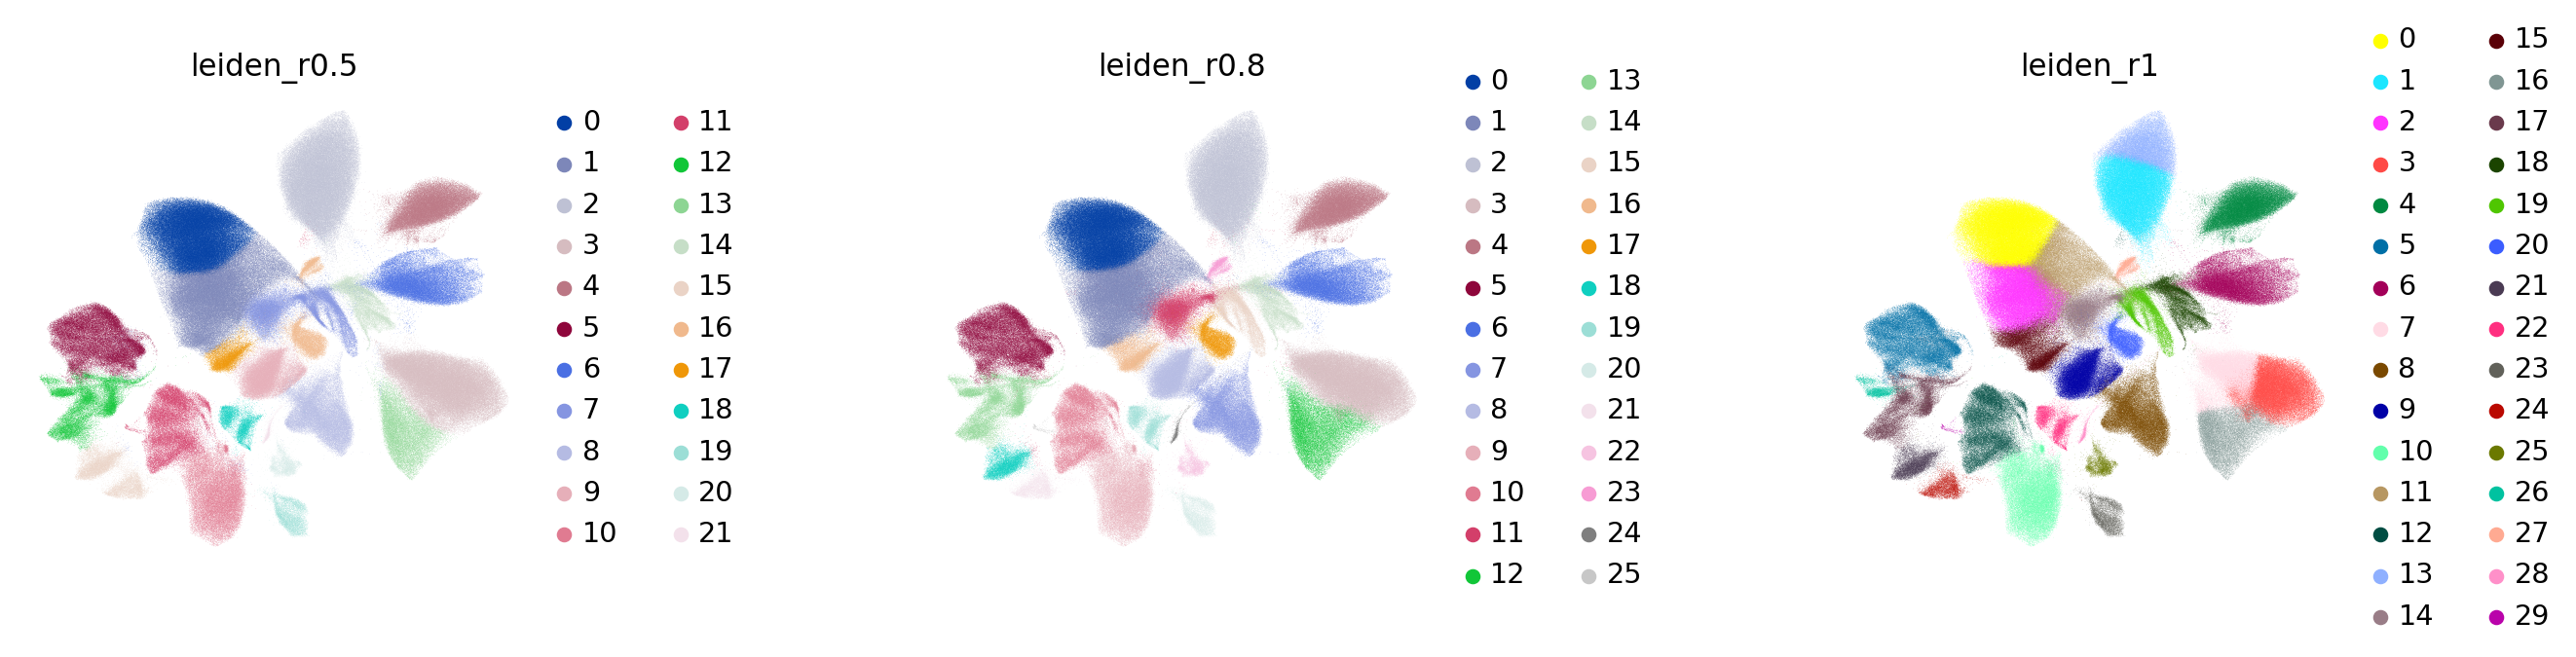

In [10]:
plt.figure()
sc.pl.umap(
    adata,
    color=["leiden_r0.5", "leiden_r0.8", "leiden_r1"],
    frameon=False,
    wspace=0.6,
)

In [11]:
# add predicted cell type labels from subclass level to obs
adata.obs['pred_subclass'] = list(adata_subclass.obs['predictions'])

In [12]:
# add predicted cell type labels for excitatory neurons from cluster level to obs
adata.obs = adata.obs.merge(adata_cluster_ex.obs['predictions'], how = 'left', left_index = True, right_index = True)
adata.obs = adata.obs.rename(columns={"predictions": "pred_cluster"})

In [ ]:
adata.obs

In [14]:
adata.obs['pred_cluster'] = adata.obs['pred_cluster'].astype('category')
adata.obs['pred_cluster'].cat.categories.tolist()

['Exc L2-3 LINC00507 RPL9P17',
 'Exc L2-4 RORB GRIK1',
 'Exc L3-4 RORB PRSS12',
 'Exc L3-5 RORB CMAHP',
 'Exc L4 RORB BHLHE22',
 'Exc L4-5 RORB LCN15',
 'Exc L4-5 RORB LINC01474',
 'Exc L4-5 RORB RPL31P31',
 'Exc L5-6 FEZF2 MYBPHL',
 'Exc L5-6 THEMIS IL7R',
 'Exc L6 FEZF2 FAM95C',
 'Exc L6 FEZF2 KRT17',
 'Exc L6 FEZF2 VWA2',
 'Exc L6 THEMIS EGR3',
 'Exc L6 THEMIS LINC00343']

In [15]:
adata.obs['pred_subclass'] = adata.obs['pred_subclass'].astype('category')
adata.obs['pred_subclass'].cat.categories.tolist()

['Astrocyte',
 'IT',
 'L4 IT',
 'L5/6 IT Car3',
 'L5/6 NP',
 'L6 CT',
 'LAMP5',
 'Microglia',
 'OPC',
 'Oligodendrocyte',
 'PVALB',
 'SST',
 'VIP']

In [ ]:
plt.figure()
sc.pl.umap(
    adata,
    color=["pred_subclass", "pred_cluster"],
    frameon=False,
    wspace=0.6,
)
sc.pl.umap(
    adata,
    color=["leiden_r1", "leiden_r0.8", "leiden_r0.5"],
    frameon=False,
    wspace=0.6,
)
sc.pl.umap(
    adata,
    color=["sample", "6-Batch"],
    frameon=False,
    wspace=0.6,
)

# 2. Assign labels to clusters

In [17]:
subclasses_ex = ['L6 CT', 'L6b', 'L5/6 IT Car3', 'L5 ET', 'L4 IT', 'IT', 'L5/6 NP']
indices = [i for i, x in enumerate(list(adata.obs['pred_subclass'])) if x in subclasses_ex]

In [18]:
adata.obs['pred_comb'] = list(adata.obs['pred_subclass'])
adata.obs.pred_comb[indices] = list(adata.obs.pred_cluster[indices])

<ipython-input-18-769d762fd8db>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs.pred_comb[indices] = list(adata.obs.pred_cluster[indices])


In [ ]:
adata.obs

In [20]:
adata.obs['pred_comb'].value_counts()

Exc L2-3 LINC00507 RPL9P17    190656
Astrocyte                     128535
Oligodendrocyte                97915
VIP                            58872
OPC                            47664
PVALB                          43191
Microglia                      42364
Exc L4-5 RORB LINC01474        31854
SST                            30649
LAMP5                          25397
Exc L4-5 RORB RPL31P31         24841
Exc L3-4 RORB PRSS12           16165
Exc L3-5 RORB CMAHP            15888
Exc L4-5 RORB LCN15            13966
Exc L2-4 RORB GRIK1            13586
Exc L6 THEMIS LINC00343         8193
Exc L6 THEMIS EGR3              7569
Exc L5-6 FEZF2 MYBPHL           3998
Exc L5-6 THEMIS IL7R            3852
Exc L6 FEZF2 KRT17              3699
Exc L6 FEZF2 FAM95C             3503
Exc L4 RORB BHLHE22              179
Exc L6 FEZF2 VWA2                 49
Name: pred_comb, dtype: int64

## 2.1 Overlap predictions and leiden_r1

In [21]:
pred_leidenr1 = pd.crosstab(adata.obs['pred_comb'],adata.obs['leiden_r1'])

In [22]:
pred_leidenr1

leiden_r1                       0      1      2      3      4      5      6  \
pred_comb                                                                     
Astrocyte                      19    432      8  52962   1024     55   3017   
Exc L2-3 LINC00507 RPL9P17  92129     81  55068      0     48     13    110   
Exc L2-4 RORB GRIK1            39     34   5336      0      5      4     31   
Exc L3-4 RORB PRSS12            6      6   3962      0      3      5      1   
Exc L3-5 RORB CMAHP             3     11    199      0      2      3     12   
Exc L4 RORB BHLHE22             0      0      3      0      5      4      1   
Exc L4-5 RORB LCN15             1      2      9      0      0      0      0   
Exc L4-5 RORB LINC01474         6     35     69      0      5      1     41   
Exc L4-5 RORB RPL31P31          1     12      8      0      2      3     11   
Exc L5-6 FEZF2 MYBPHL           0      0      2      0      3      0      2   
Exc L5-6 THEMIS IL7R            8      1      4      0      0      1      7   
Exc L6 FEZF2 FAM95C             2      0      0      0      1      0      1   
Exc L6 FEZF2 KRT17              4      1      1      0      1      1      0   
Exc L6 FEZF2 VWA2               0      0      0      0      0      0      0   
Exc L6 THEMIS EGR3              5     23     20      0      3      0     14   
Exc L6 THEMIS LINC00343        12      4      9      0      0      0      3   
LAMP5                           1     11      2      0      0     56     12   
Microglia                      14     68      1      0      3      2  34848   
OPC                            24     52      9      0  44262    169     10   
Oligodendrocyte                39  66625      5      2    197     39   1472   
PVALB                           0      5      2      0      4     23      8   
SST                             0      2      4      0      9     85      3   
VIP                             4      7      1      0     23  41437      5   

leiden_r1                       7      8      9  ...    20    21    22    23  \
pred_comb                                        ...                           
Astrocyte                   38780      2      4  ...     0    51     3   144   
Exc L2-3 LINC00507 RPL9P17     72    174     53  ...  1196     1   104     1   
Exc L2-4 RORB GRIK1            41     21    157  ...    44     0     2     1   
Exc L3-4 RORB PRSS12            3    136     64  ...     3     0     1     0   
Exc L3-5 RORB CMAHP             6    726   2323  ...    58     0    11     1   
Exc L4 RORB BHLHE22             2     14     15  ...     0     1     0     0   
Exc L4-5 RORB LCN15             2  13525      0  ...     4     0    18     0   
Exc L4-5 RORB LINC01474        26     53  30170  ...    13     1     2     0   
Exc L4-5 RORB RPL31P31         15  22096    969  ...    42     0    32     0   
Exc L5-6 FEZF2 MYBPHL           2     47      1  ...     0     0    20     0   
Exc L5-6 THEMIS IL7R            1      2      5  ...   177     0    76     0   
Exc L6 FEZF2 FAM95C             2     22      4  ...    14     0  3406     0   
Exc L6 FEZF2 KRT17              1      4      0  ...     2     0  3636     0   
Exc L6 FEZF2 VWA2               0      0      0  ...     0     0    41     1   
Exc L6 THEMIS EGR3             18     36    873  ...  1884     0     8     0   
Exc L6 THEMIS LINC00343         2     43     39  ...  7825     0    33     0   
LAMP5                          13      1      0  ...     2  9645     0    31   
Microglia                      35      0      0  ...     0     0     0     1   
OPC                            57     27     13  ...    11     1    72     0   
Oligodendrocyte               367      2      0  ...     8     5     4     0   
PVALB                          19     13      0  ...     0    10     3  6479   
SST                            21    189     18  ...     5     6    23     7   
VIP                            25      5      0  ...     7    61   155    59   

leiden_r1              

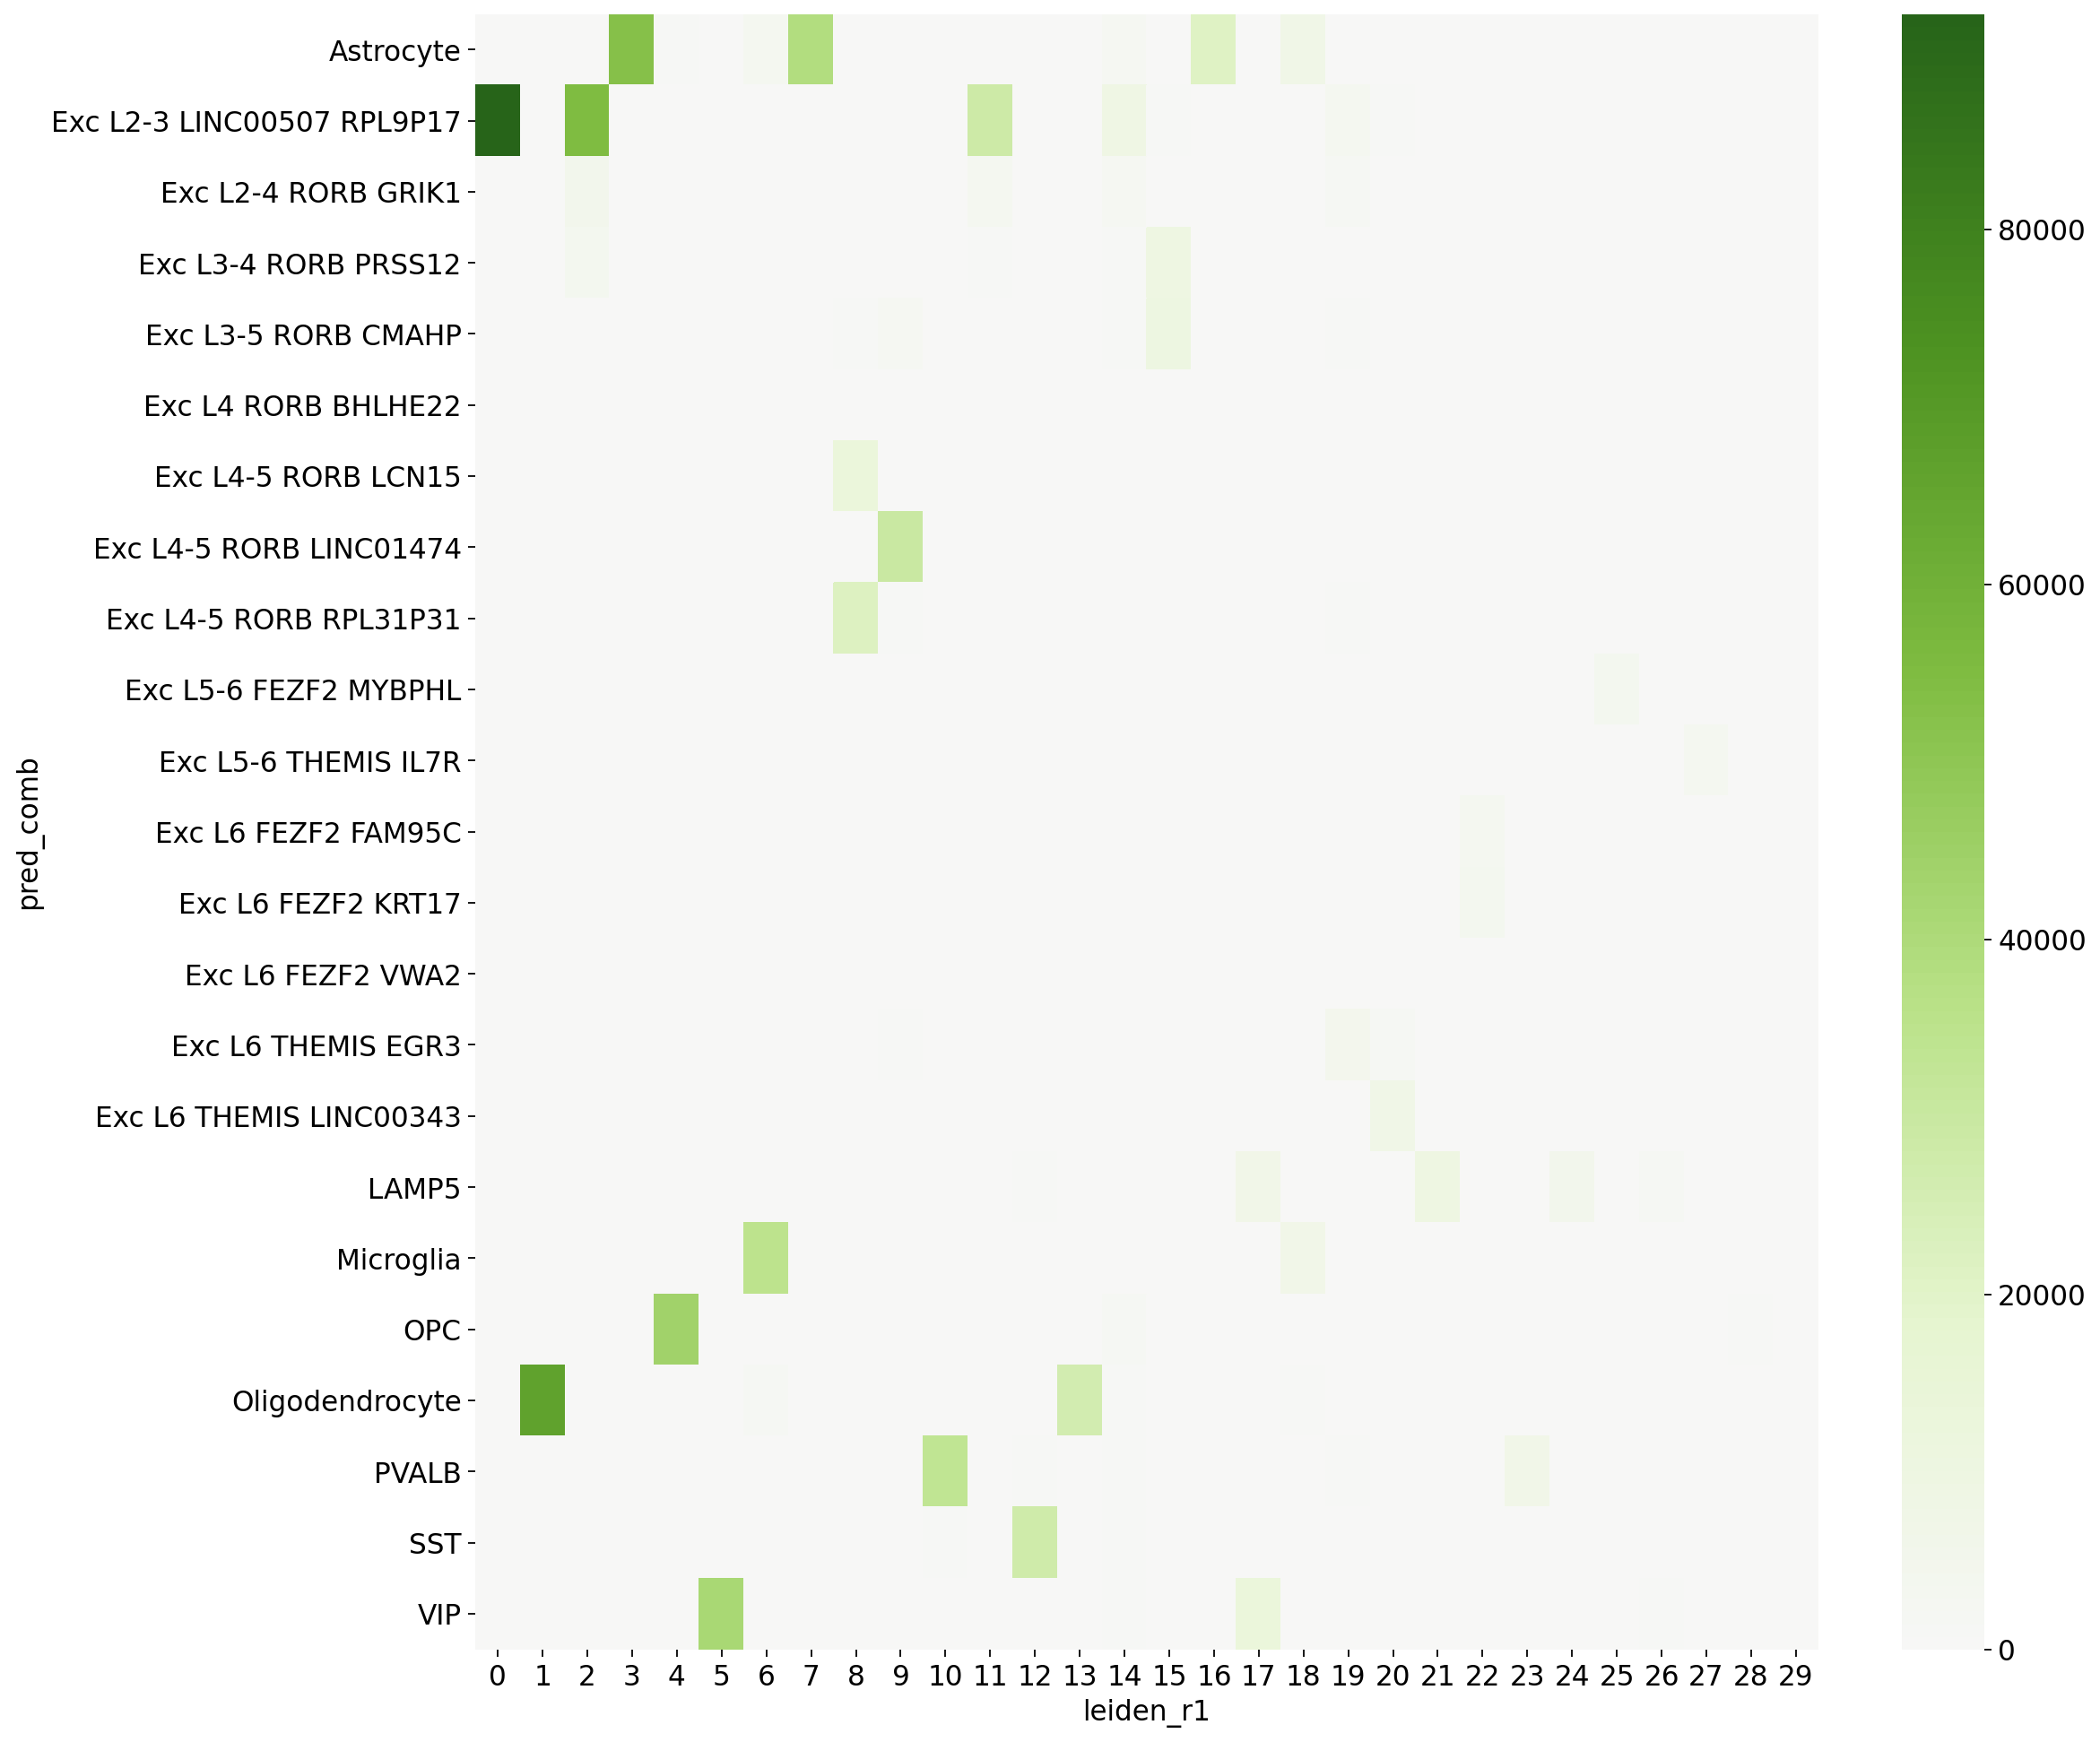

In [23]:
sc.settings.set_figure_params(dpi=400, frameon=False)
sc.set_figure_params(dpi=400)
sc.set_figure_params(figsize=(15, 15))
ax = sb.heatmap(pred_leidenr1, cmap="PiYG", center = 0)

In [24]:
# get label with maximal overlap per cluster
max_leidenr1 = pred_leidenr1.idxmax(axis=0).to_frame(name = "label")
max_leidenr1 = dict(zip(max_leidenr1.index, max_leidenr1.label))
print(max_leidenr1)

{'0': 'Exc L2-3 LINC00507 RPL9P17', '1': 'Oligodendrocyte', '2': 'Exc L2-3 LINC00507 RPL9P17', '3': 'Astrocyte', '4': 'OPC', '5': 'VIP', '6': 'Microglia', '7': 'Astrocyte', '8': 'Exc L4-5 RORB RPL31P31', '9': 'Exc L4-5 RORB LINC01474', '10': 'PVALB', '11': 'Exc L2-3 LINC00507 RPL9P17', '12': 'SST', '13': 'Oligodendrocyte', '14': 'Exc L2-3 LINC00507 RPL9P17', '15': 'Exc L3-5 RORB CMAHP', '16': 'Astrocyte', '17': 'VIP', '18': 'Astrocyte', '19': 'Exc L6 THEMIS EGR3', '20': 'Exc L6 THEMIS LINC00343', '21': 'LAMP5', '22': 'Exc L6 FEZF2 KRT17', '23': 'PVALB', '24': 'LAMP5', '25': 'Exc L5-6 FEZF2 MYBPHL', '26': 'LAMP5', '27': 'Exc L5-6 THEMIS IL7R', '28': 'OPC', '29': 'SST'}


In [25]:
# assign cell type per cluster according to highest overlap
adata.obs['celltype_r1'] = adata.obs['leiden_r1'].map(max_leidenr1)

In [26]:
pd.crosstab(adata.obs['celltype_r1'],adata.obs['leiden_r1'])

leiden_r1                       0      1      2      3      4      5      6  \
celltype_r1                                                                   
Astrocyte                       0      0      0  52964      0      0      0   
Exc L2-3 LINC00507 RPL9P17  92317      0  64722      0      0      0      0   
Exc L3-5 RORB CMAHP             0      0      0      0      0      0      0   
Exc L4-5 RORB LINC01474         0      0      0      0      0      0      0   
Exc L4-5 RORB RPL31P31          0      0      0      0      0      0      0   
Exc L5-6 FEZF2 MYBPHL           0      0      0      0      0      0      0   
Exc L5-6 THEMIS IL7R            0      0      0      0      0      0      0   
Exc L6 FEZF2 KRT17              0      0      0      0      0      0      0   
Exc L6 THEMIS EGR3              0      0      0      0      0      0      0   
Exc L6 THEMIS LINC00343         0      0      0      0      0      0      0   
LAMP5                           0      0      0      0      0      0      0   
Microglia                       0      0      0      0      0      0  39609   
OPC                             0      0      0      0  45600      0      0   
Oligodendrocyte                 0  67412      0      0      0      0      0   
PVALB                           0      0      0      0      0      0      0   
SST                             0      0      0      0      0      0      0   
VIP                             0      0      0      0      0  41901      0   

leiden_r1                       7      8      9  ...     20    21    22    23  \
celltype_r1                                      ...                            
Astrocyte                   39510      0      0  ...      0     0     0     0   
Exc L2-3 LINC00507 RPL9P17      0      0      0  ...      0     0     0     0   
Exc L3-5 RORB CMAHP             0      0      0  ...      0     0     0     0   
Exc L4-5 RORB LINC01474         0      0  34708  ...      0     0     0     0   
Exc L4-5 RORB RPL31P31          0  37138      0  ...      0     0     0     0   
Exc L5-6 FEZF2 MYBPHL           0      0      0  ...      0     0     0     0   
Exc L5-6 THEMIS IL7R            0      0      0  ...      0     0     0     0   
Exc L6 FEZF2 KRT17              0      0      0  ...      0     0  7650     0   
Exc L6 THEMIS EGR3              0      0      0  ...      0     0     0     0   
Exc L6 THEMIS LINC00343         0      0      0  ...  11295     0     0     0   
LAMP5                           0      0      0  ...      0  9782     0     0   
Microglia                       0      0      0  ...      0     0     0     0   
OPC                             0      0      0  ...      0     0     0     0   
Oligodendrocyte                 0      0      0  ...      0     0     0     0   
PVALB                           0      0      0  ...      0     0     0  6725   
SST                             0      0      0  ...      0     0     0     0   
VIP                             0      0      0  ...      0     0     0     0   

leiden_r1                     24    25    26    27    28   29  
celltype_r1                                                    
Astrocyte                      0     0     0     0     0    0  
Exc L2-3 LINC00507 RPL9P17     0     0     0     0     0    0  
Exc L3-5 RORB CMAHP            0     0     0     0     0    0  
Exc L4-5 RORB LINC01474        0     0     0     0     0    0  
Exc L4-5 RORB RPL31P31         0     0     0     0     0    0  
Exc L5-6 FEZF2 MYBPHL          0  4215     0     0     0    0  
Exc L5-6 THEMIS IL7R           0     0     0  3419     0    0  
Exc L6 FEZF2 KRT17             0     0     0     0     0    0  
Exc L6 THEMIS EGR3             0     0     0     0     0    0  
Exc L6 THEMIS LINC00343        0     0     0     0     0    0  
LAMP5                       5419     0  3520     0     0    0  
Microglia                      0     0     0     0     0    0  
OPC                            0     0     0     0  1176    0 

## 2.2 Overlap predictions and leiden_r0.8

In [27]:
pred_leidenr08 = pd.crosstab(adata.obs['pred_comb'],adata.obs['leiden_r0.8'])

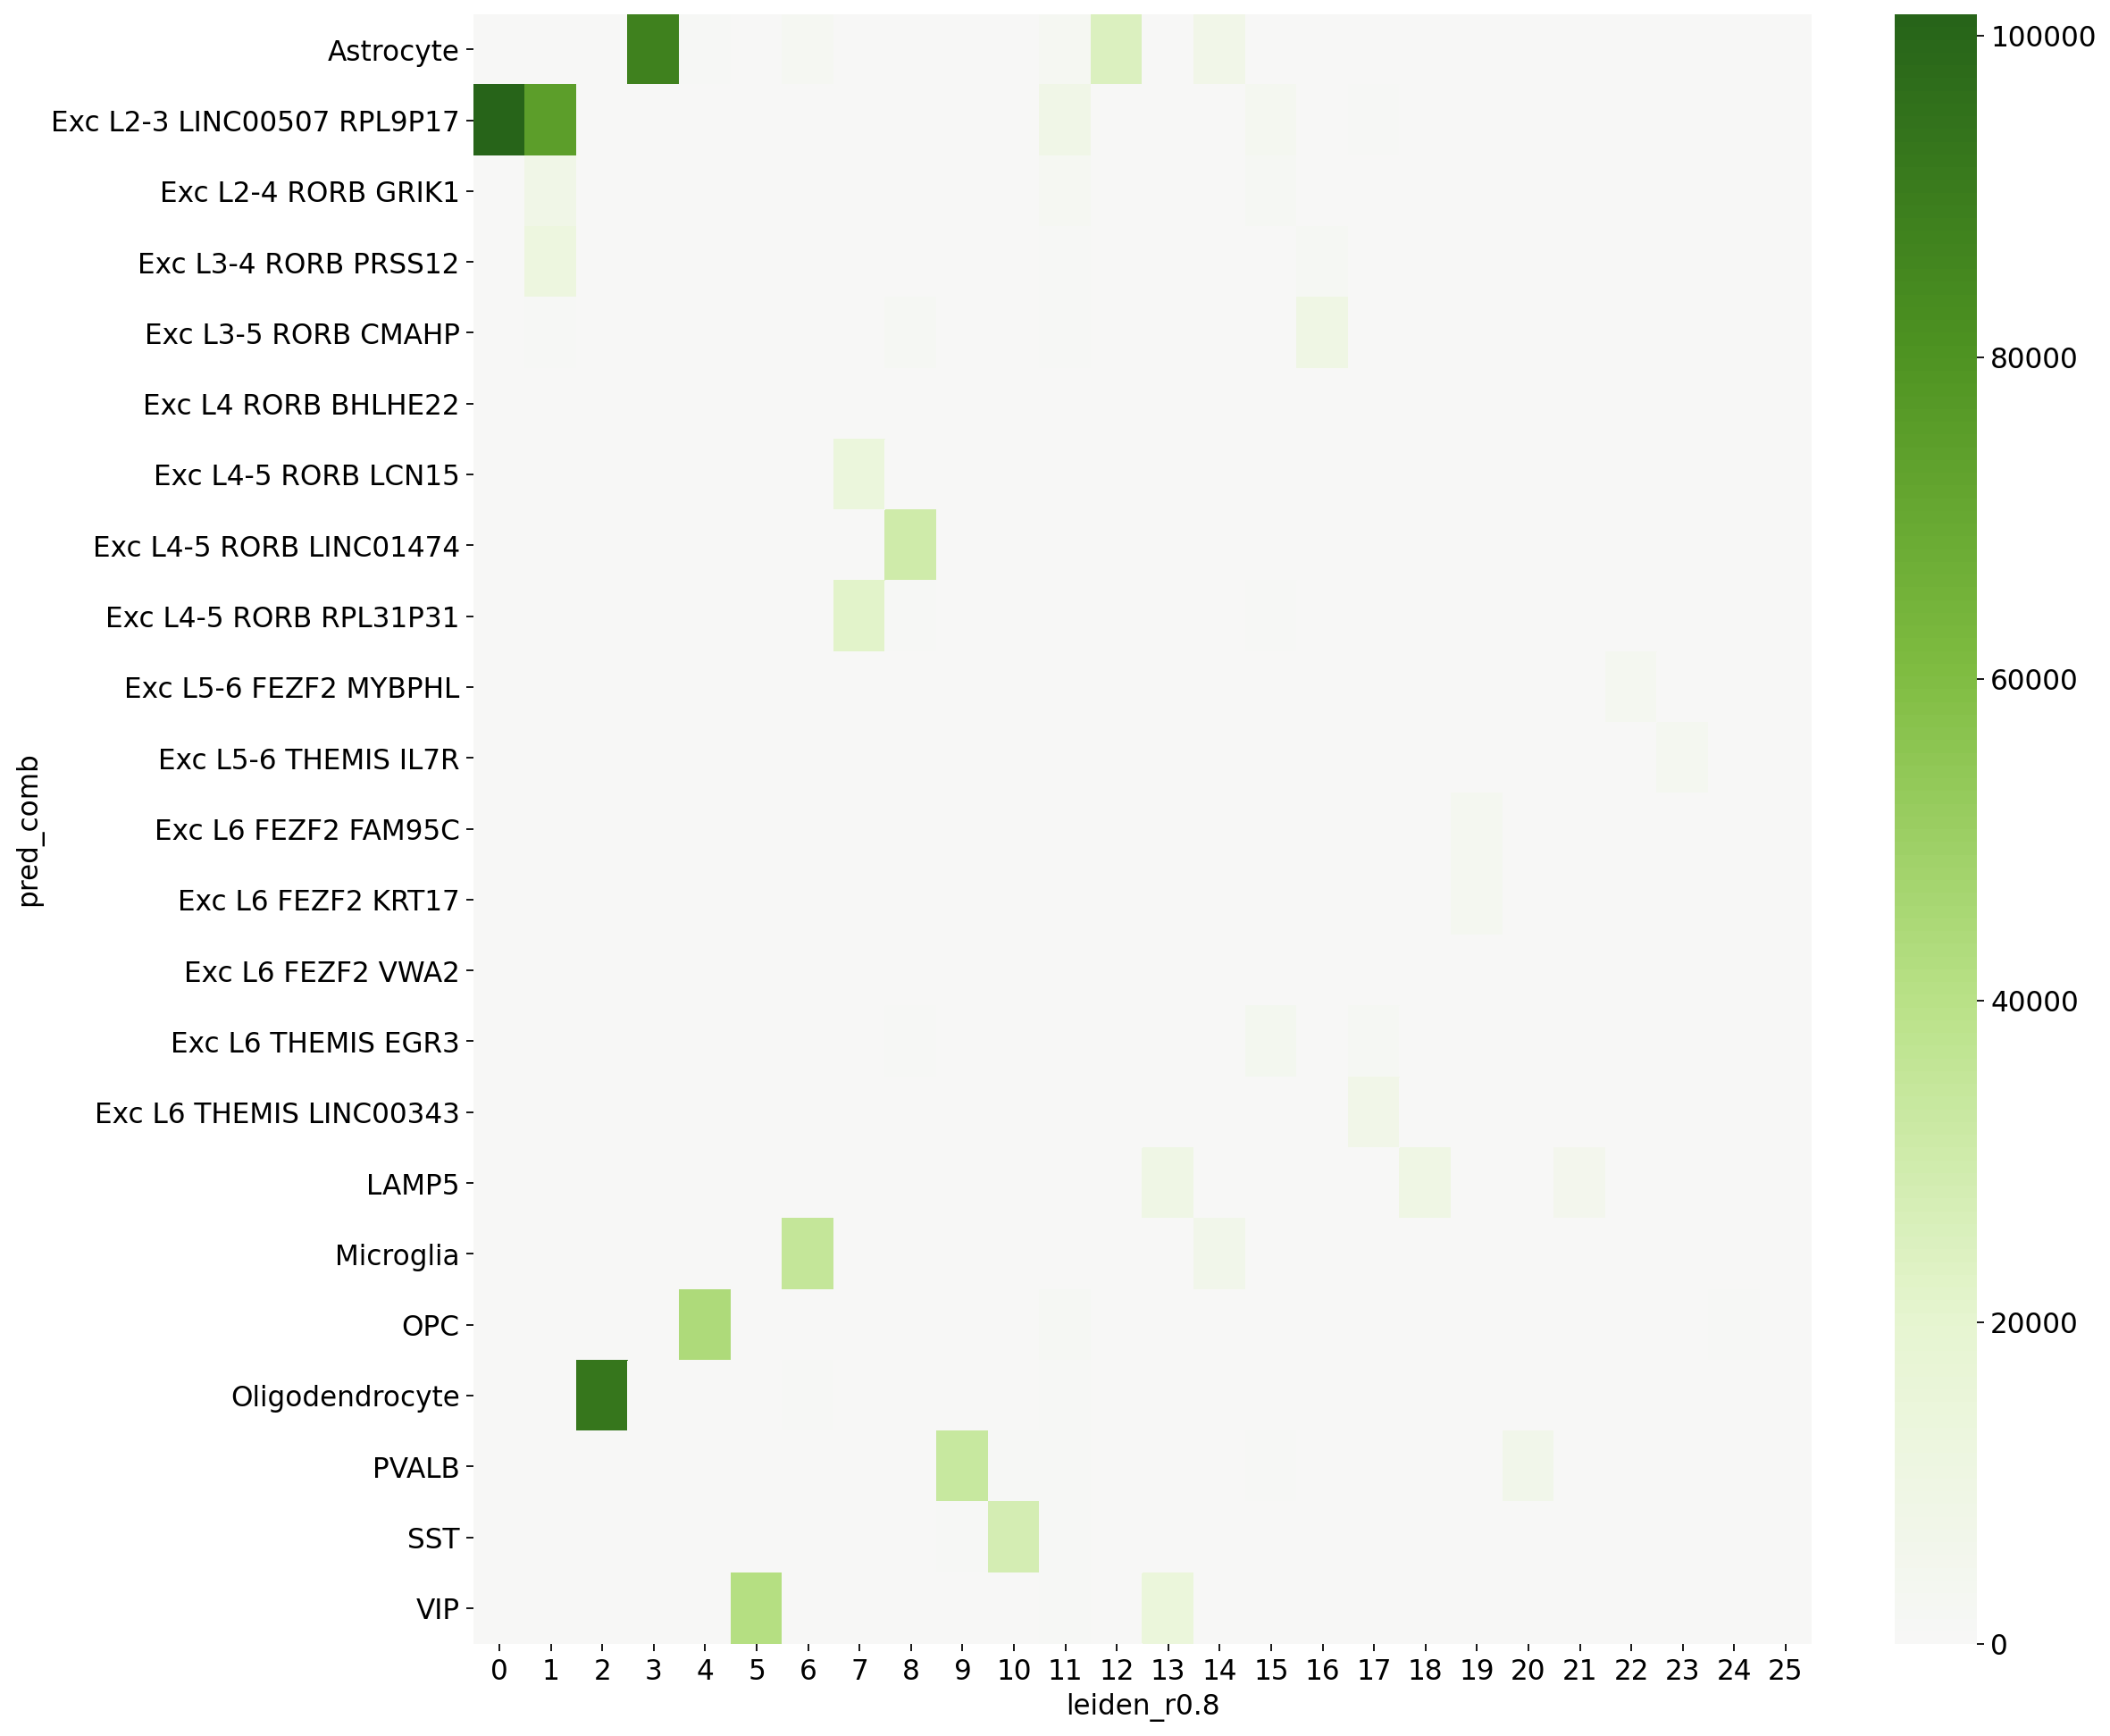

In [28]:
sc.settings.set_figure_params(dpi=400, frameon=False)
sc.set_figure_params(dpi=400)
sc.set_figure_params(figsize=(15, 15))
ax = sb.heatmap(pred_leidenr08, cmap="PiYG", center = 0)

In [29]:
# get label with maximal overlap per cluster
max_leidenr08 = pred_leidenr08.idxmax(axis=0).to_frame(name = "label")
max_leidenr08 = dict(zip(max_leidenr08.index, max_leidenr08.label))
max_leidenr08

{'0': 'Exc L2-3 LINC00507 RPL9P17',
 '1': 'Exc L2-3 LINC00507 RPL9P17',
 '2': 'Oligodendrocyte',
 '3': 'Astrocyte',
 '4': 'OPC',
 '5': 'VIP',
 '6': 'Microglia',
 '7': 'Exc L4-5 RORB RPL31P31',
 '8': 'Exc L4-5 RORB LINC01474',
 '9': 'PVALB',
 '10': 'SST',
 '11': 'Exc L2-3 LINC00507 RPL9P17',
 '12': 'Astrocyte',
 '13': 'VIP',
 '14': 'Astrocyte',
 '15': 'Exc L6 THEMIS EGR3',
 '16': 'Exc L3-5 RORB CMAHP',
 '17': 'Exc L6 THEMIS LINC00343',
 '18': 'LAMP5',
 '19': 'Exc L6 FEZF2 KRT17',
 '20': 'PVALB',
 '21': 'LAMP5',
 '22': 'Exc L5-6 FEZF2 MYBPHL',
 '23': 'Exc L5-6 THEMIS IL7R',
 '24': 'OPC',
 '25': 'SST'}

In [30]:
# assign cell type per cluster according to highest overlap
adata.obs['celltype_r0.8'] = adata.obs['leiden_r0.8'].map(max_leidenr08)

In [ ]:
adata.obs

In [32]:
# dataframe is "fragmented" due to too many merge steps and so on
new_obs = adata.obs.copy()
adata.obs = new_obs.copy()
del new_obs

In [33]:
# reset plot settings
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))

<Figure size 320x320 with 0 Axes>

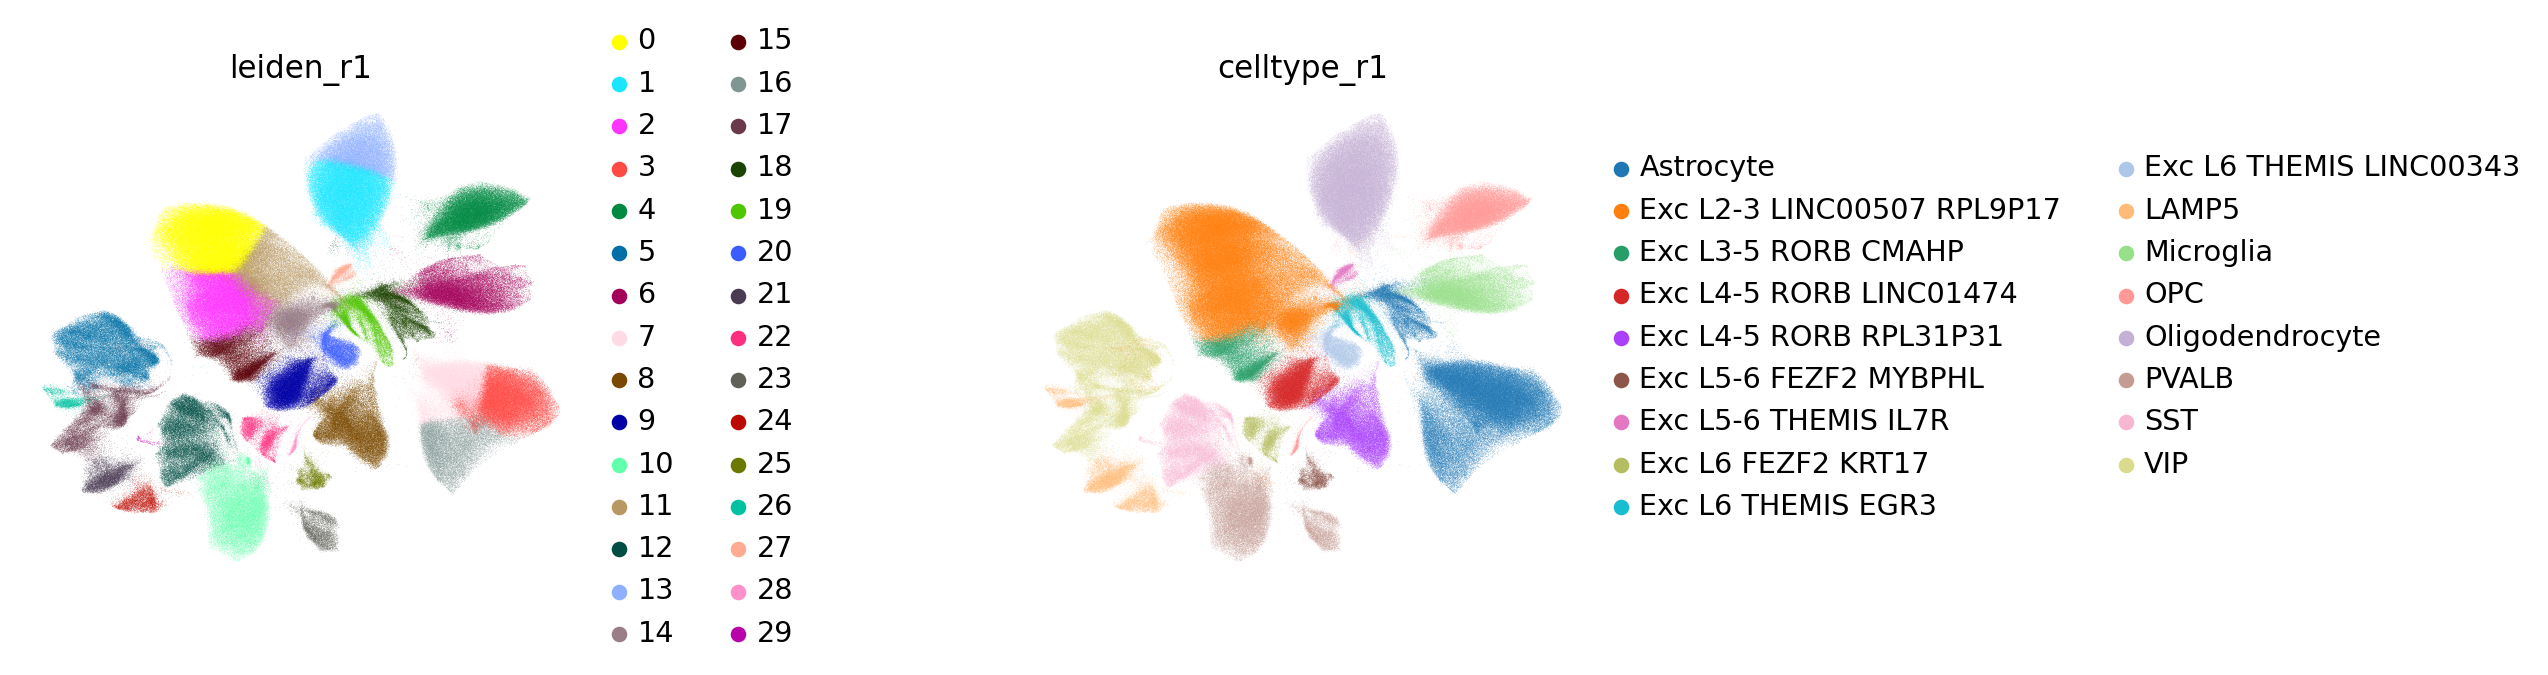

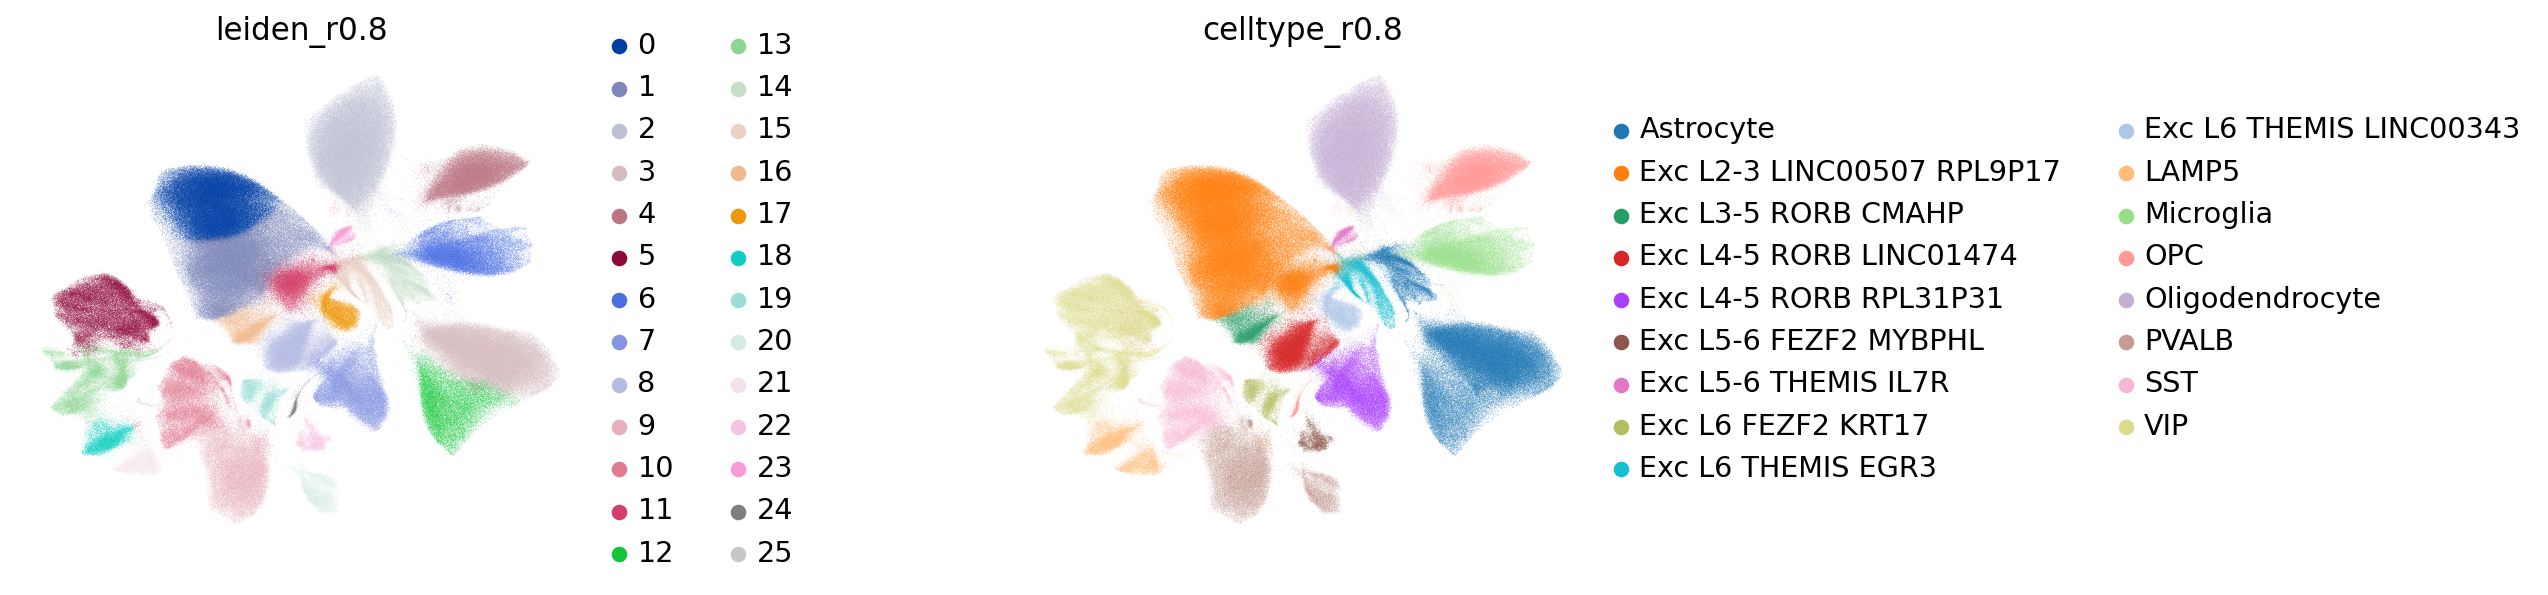

In [34]:
plt.figure()
sc.pl.umap(
    adata,
    color=["leiden_r1", "celltype_r1"],
    frameon=False,
    wspace=0.6,
)
sc.pl.umap(
    adata,
    color=["leiden_r0.8", "celltype_r0.8"],
    frameon=False,
    wspace=0.6,
)

# 3. Marker genes per cluster

Marker gene detection should be run on normalized, log-transformed, but uncorrected data. --> adata.X is normalized but not log-transformed so far

In [35]:
sc.pp.log1p(adata)

In [36]:
print(adata.X)

  (0, 37)	1.0986122886681096
  (0, 135)	0.6931471805599453
  (0, 154)	1.9459101490553132
  (0, 156)	1.0986122886681096
  (0, 176)	0.6931471805599453
  (0, 195)	1.0986122886681096
  (0, 227)	2.1972245773362196
  (0, 318)	0.6931471805599453
  (0, 369)	1.0986122886681096
  (0, 374)	1.0986122886681096
  (0, 381)	1.3862943611198906
  (0, 441)	1.0986122886681096
  (0, 575)	1.0986122886681096
  (0, 611)	1.0986122886681096
  (0, 627)	0.6931471805599453
  (0, 707)	1.0986122886681096
  (0, 714)	1.0986122886681096
  (0, 724)	1.6094379124341003
  (0, 780)	1.0986122886681096
  (0, 788)	0.6931471805599453
  (0, 799)	0.6931471805599453
  (0, 808)	1.0986122886681096
  (0, 825)	1.3862943611198906
  (0, 844)	1.0986122886681096
  (0, 878)	0.6931471805599453
  :	:
  (812584, 26054)	0.6931471805599453
  (812584, 26060)	0.6931471805599453
  (812584, 26062)	0.6931471805599453
  (812584, 26063)	0.6931471805599453
  (812584, 26078)	0.6931471805599453
  (812584, 26088)	0.6931471805599453
  (812584, 26090)	0.693

In [37]:
# without log transformation
#print(adata.X)

## 3.1 Marker genes for resolution 1

In [38]:
sc.tl.rank_genes_groups(adata, groupby = "leiden_r1", key_added='rank_genes_r1', use_raw = False)

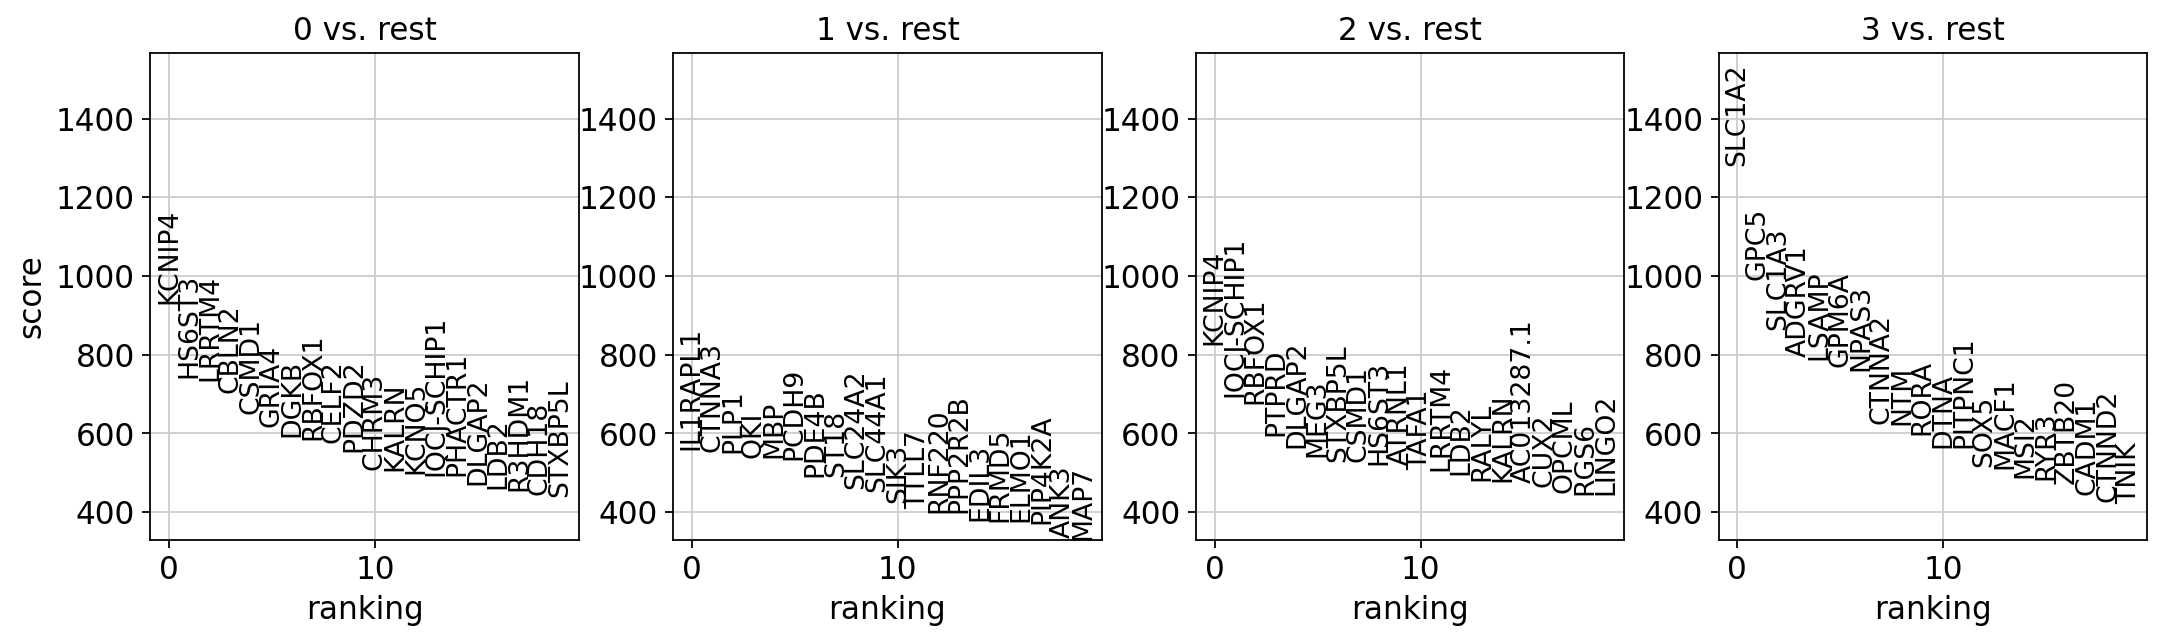

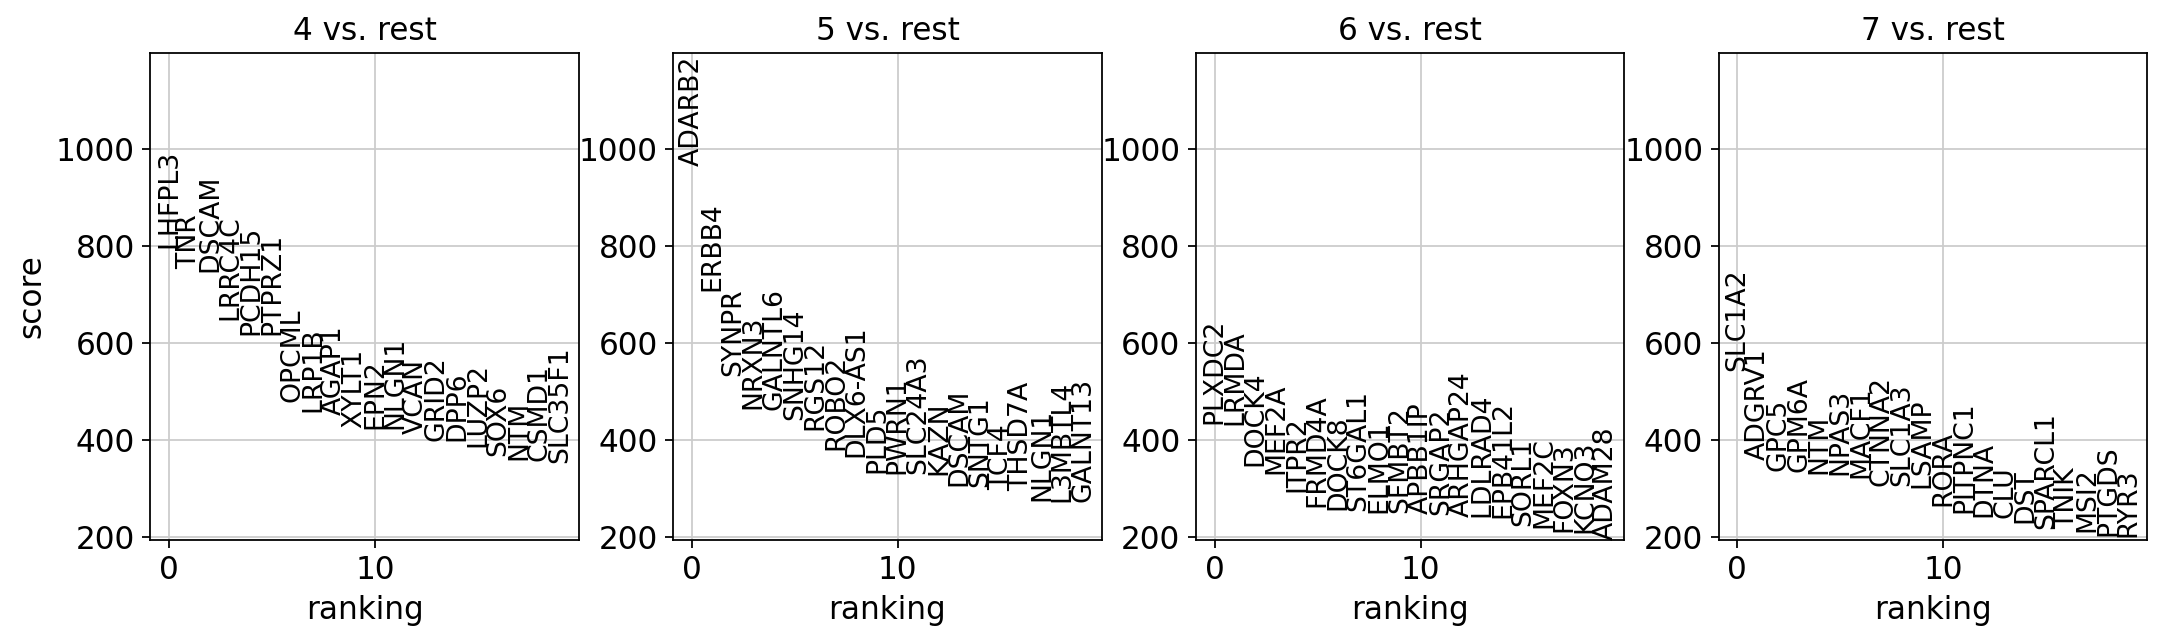

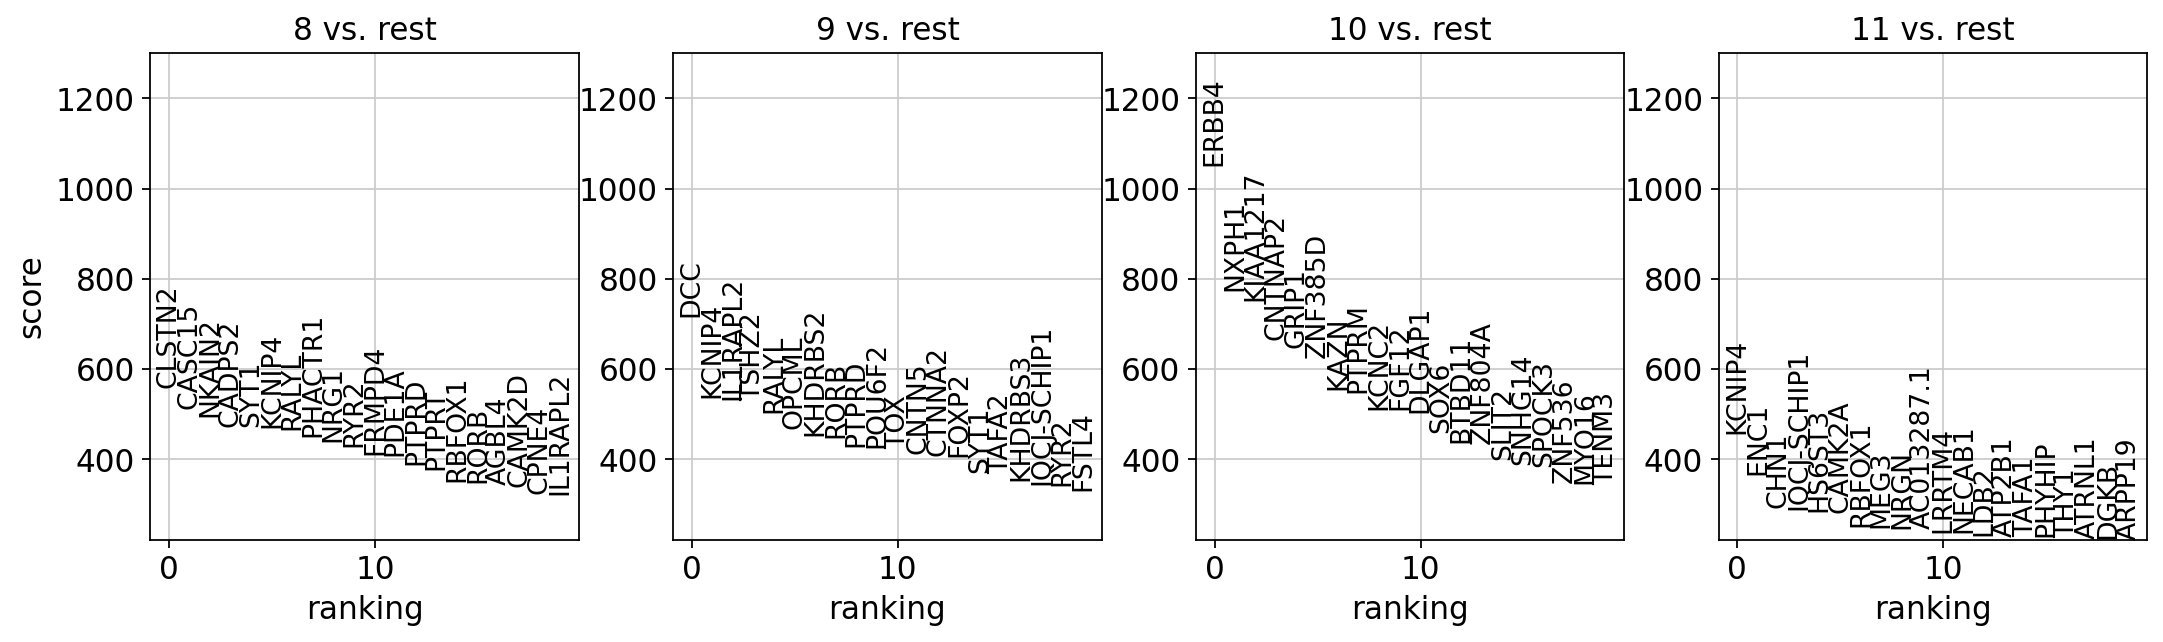

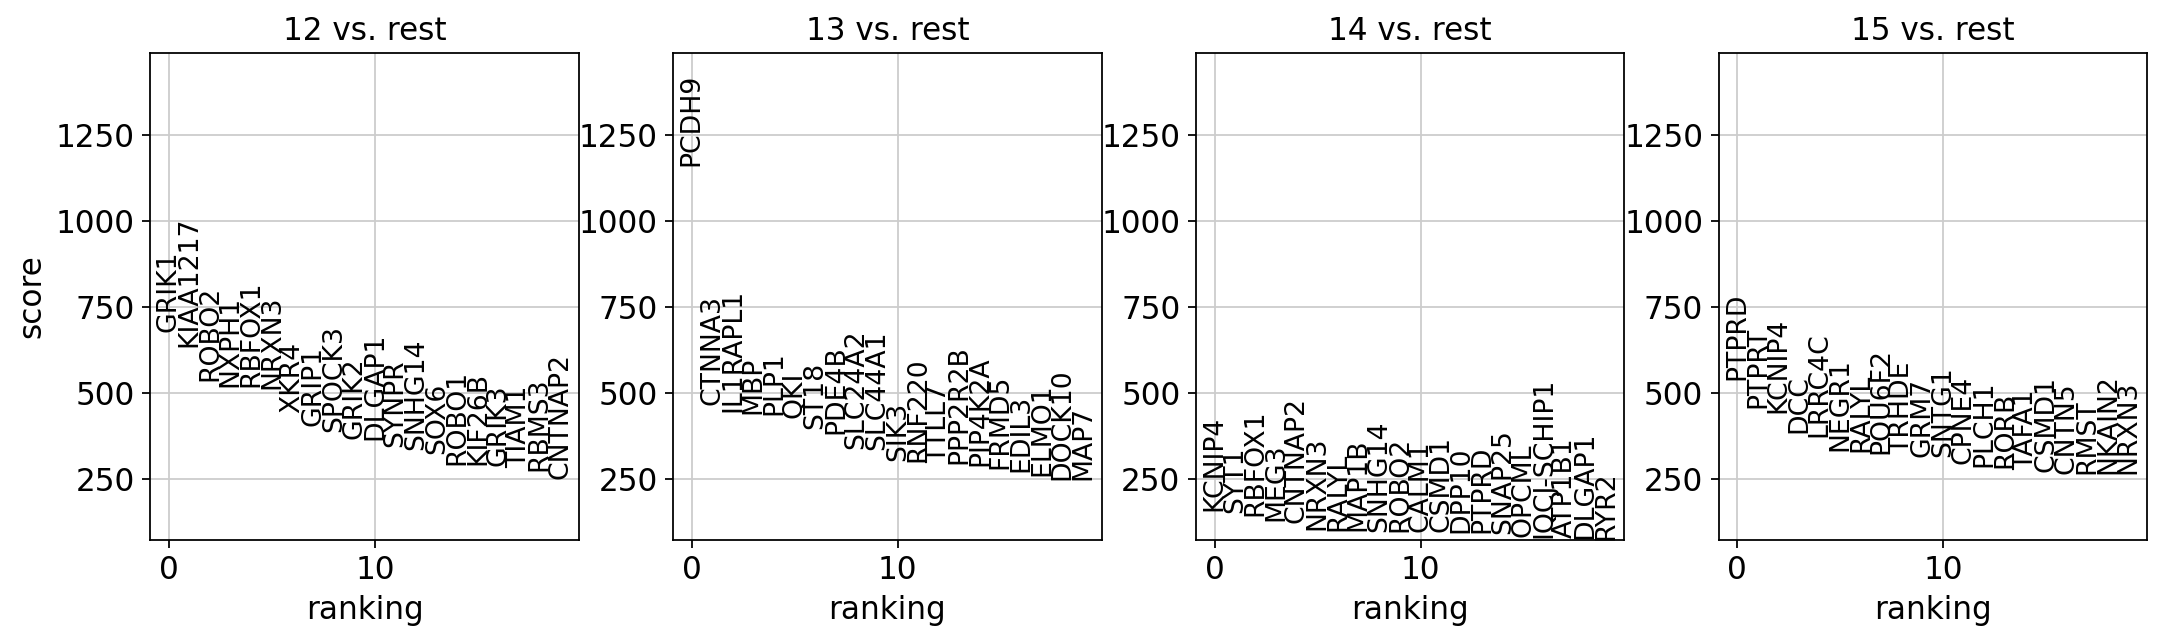

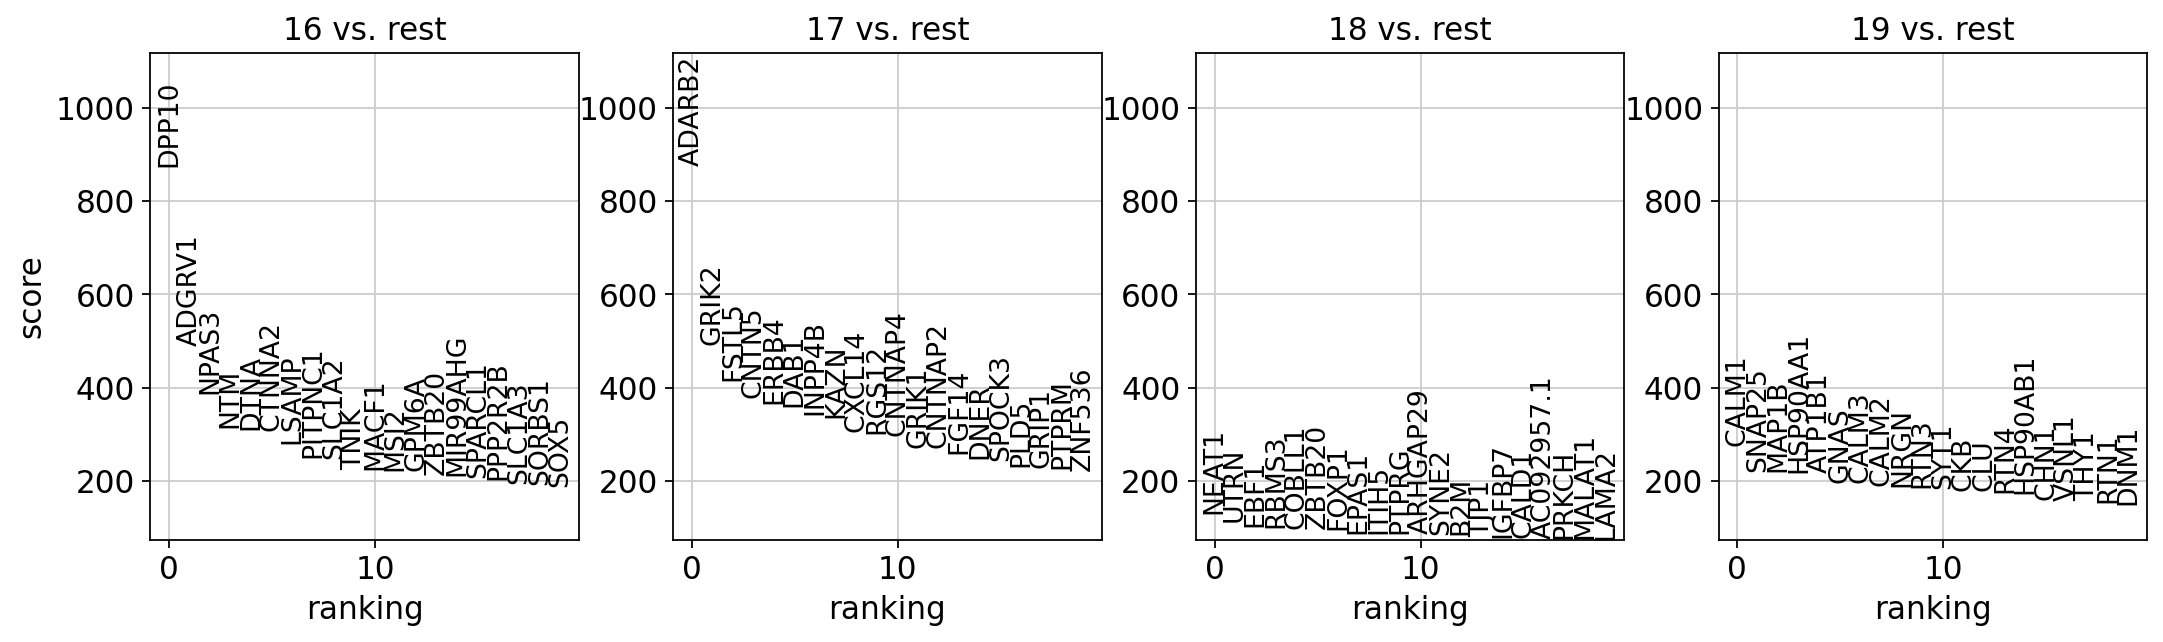

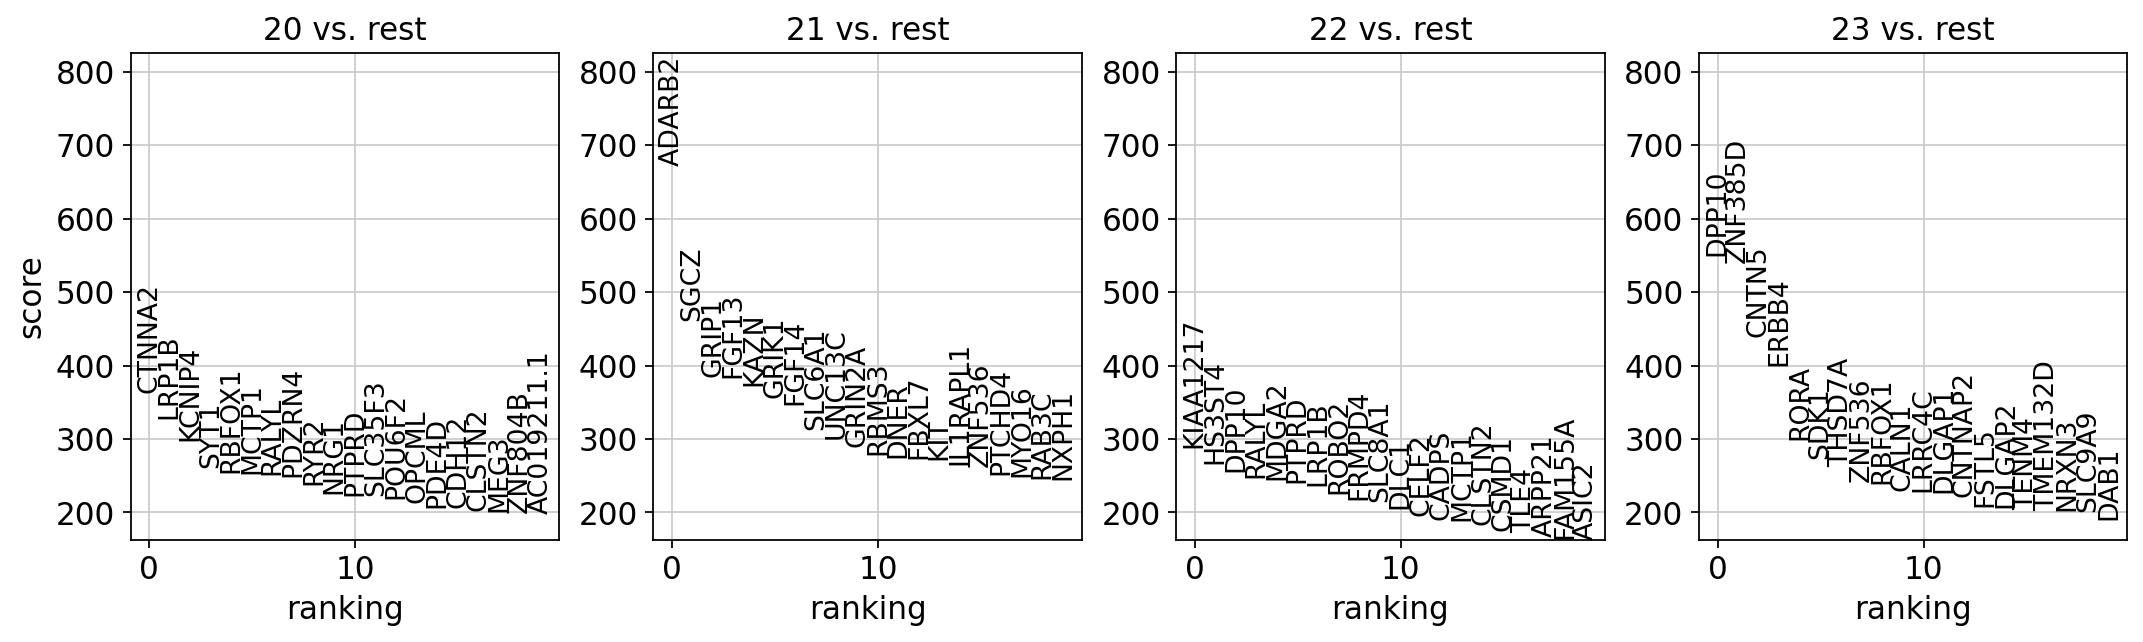

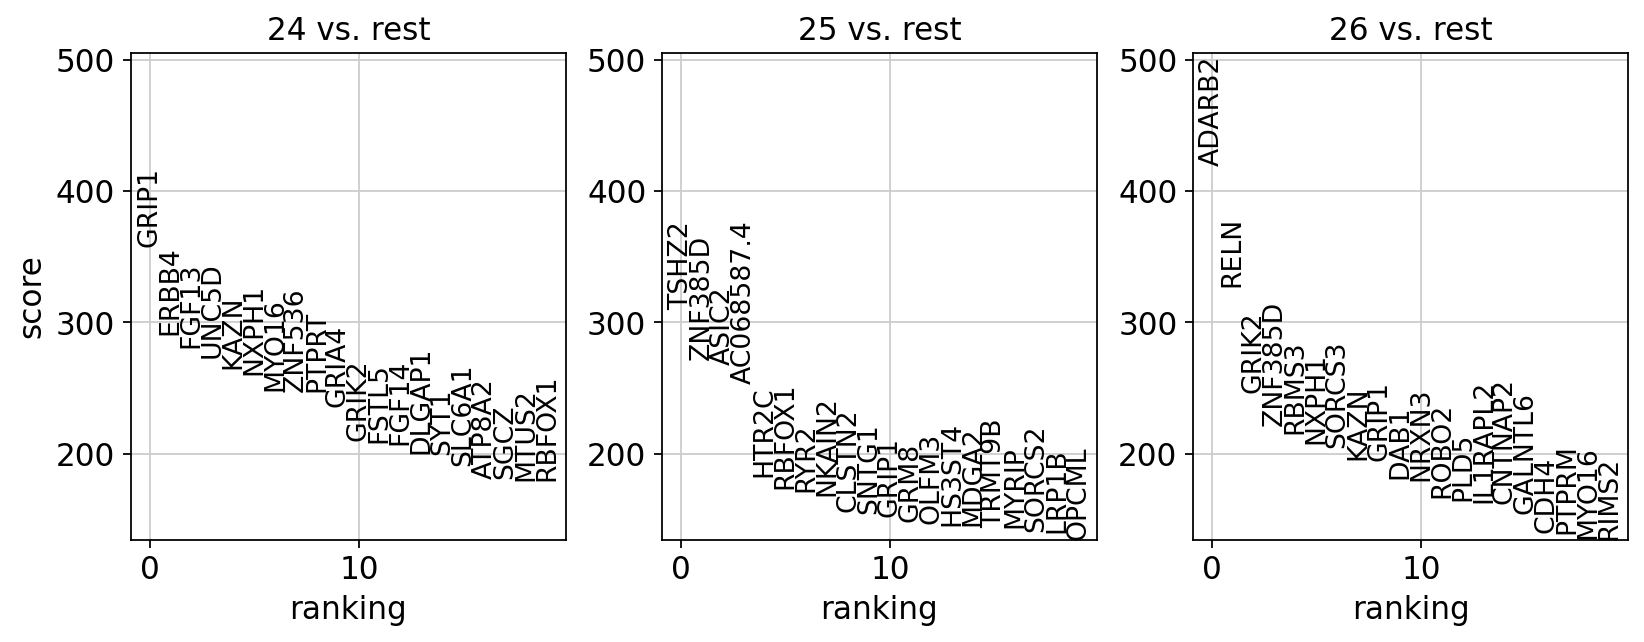

In [39]:
#Plot marker genes
sc.pl.rank_genes_groups(adata, key='rank_genes_r1', groups=['0','1','2','3'], fontsize=12)
sc.pl.rank_genes_groups(adata, key='rank_genes_r1', groups=['4','5','6','7'], fontsize=12)
sc.pl.rank_genes_groups(adata, key='rank_genes_r1', groups=['8','9','10','11'], fontsize=12)
sc.pl.rank_genes_groups(adata, key='rank_genes_r1', groups=['12','13','14','15'], fontsize=12)
sc.pl.rank_genes_groups(adata, key='rank_genes_r1', groups=['16','17','18','19'], fontsize=12)
sc.pl.rank_genes_groups(adata, key='rank_genes_r1', groups=['20','21','22','23'], fontsize=12)
sc.pl.rank_genes_groups(adata, key='rank_genes_r1', groups=['24','25','26'], fontsize=12)

## 3.2 Marker genes for resolution 0.8

In [40]:
sc.tl.rank_genes_groups(adata, groupby = "leiden_r0.8", key_added='rank_genes_r0.8', use_raw = False)

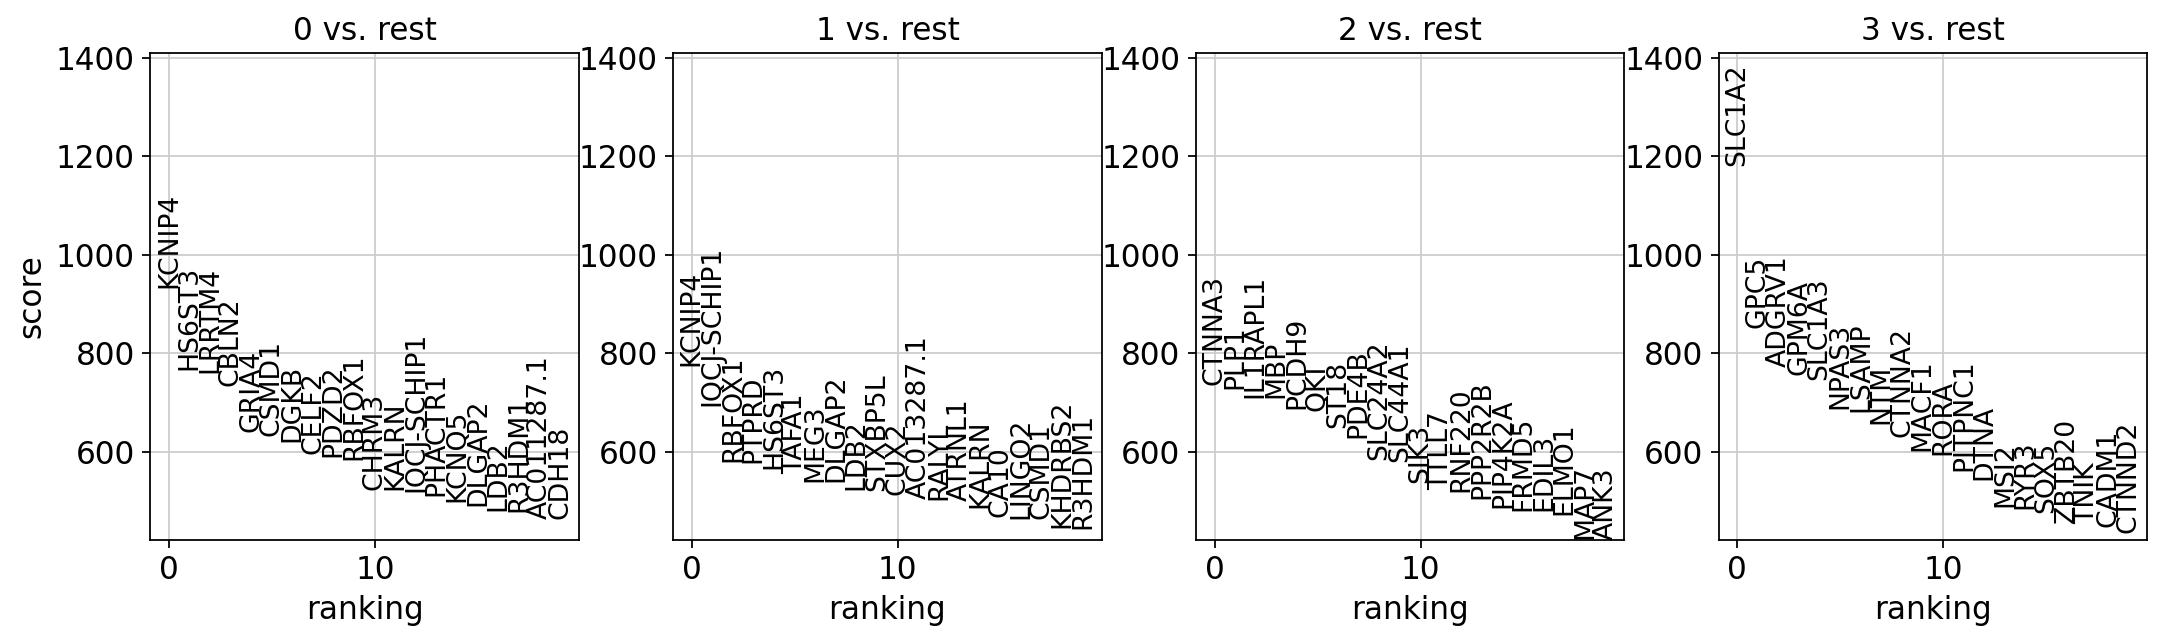

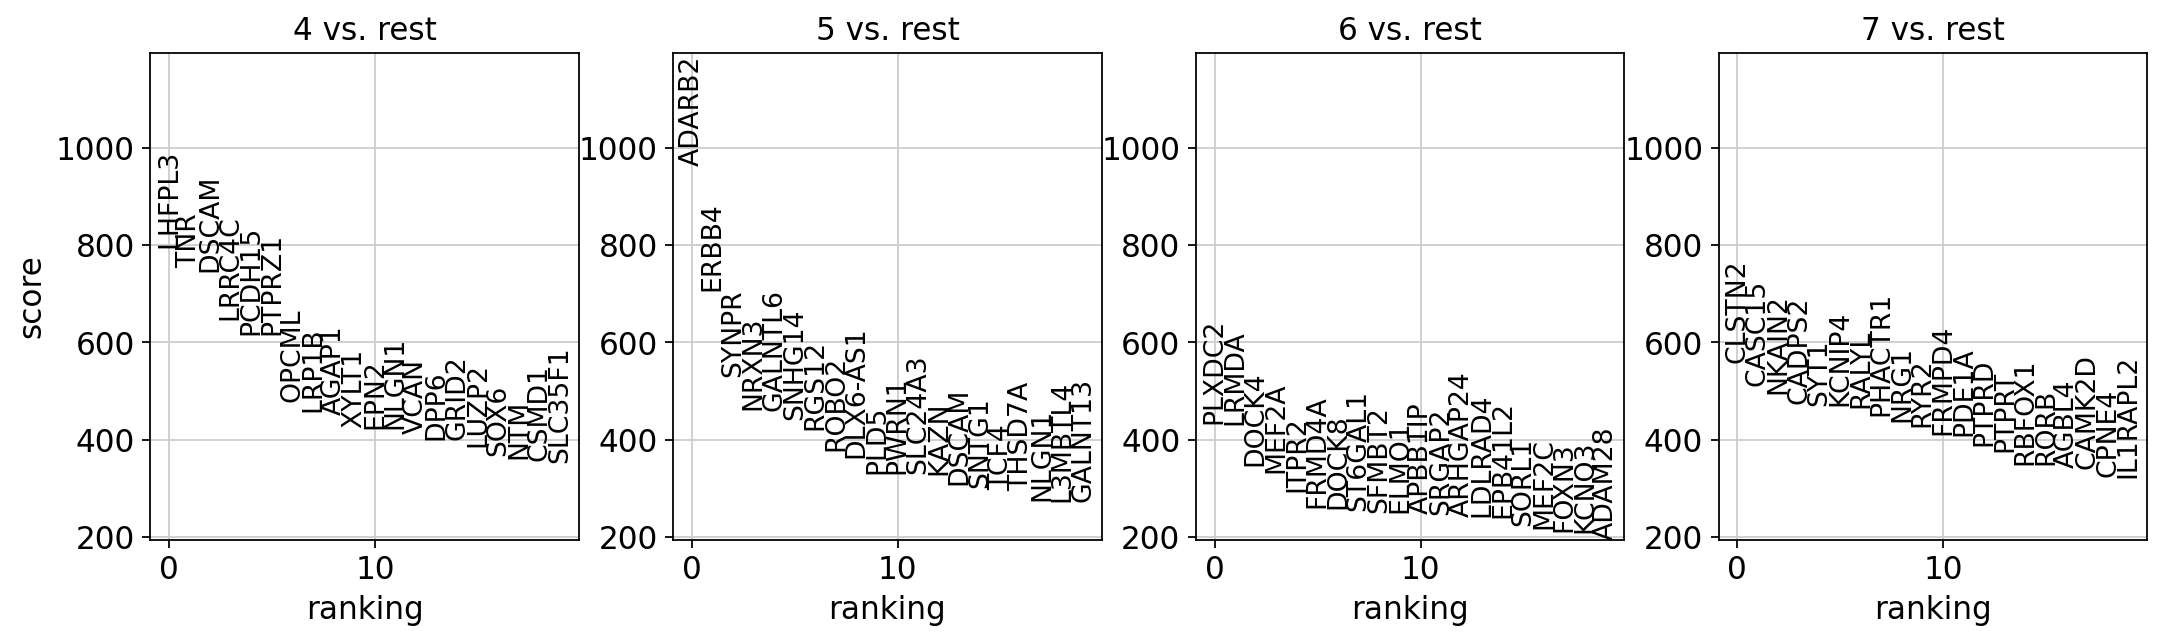

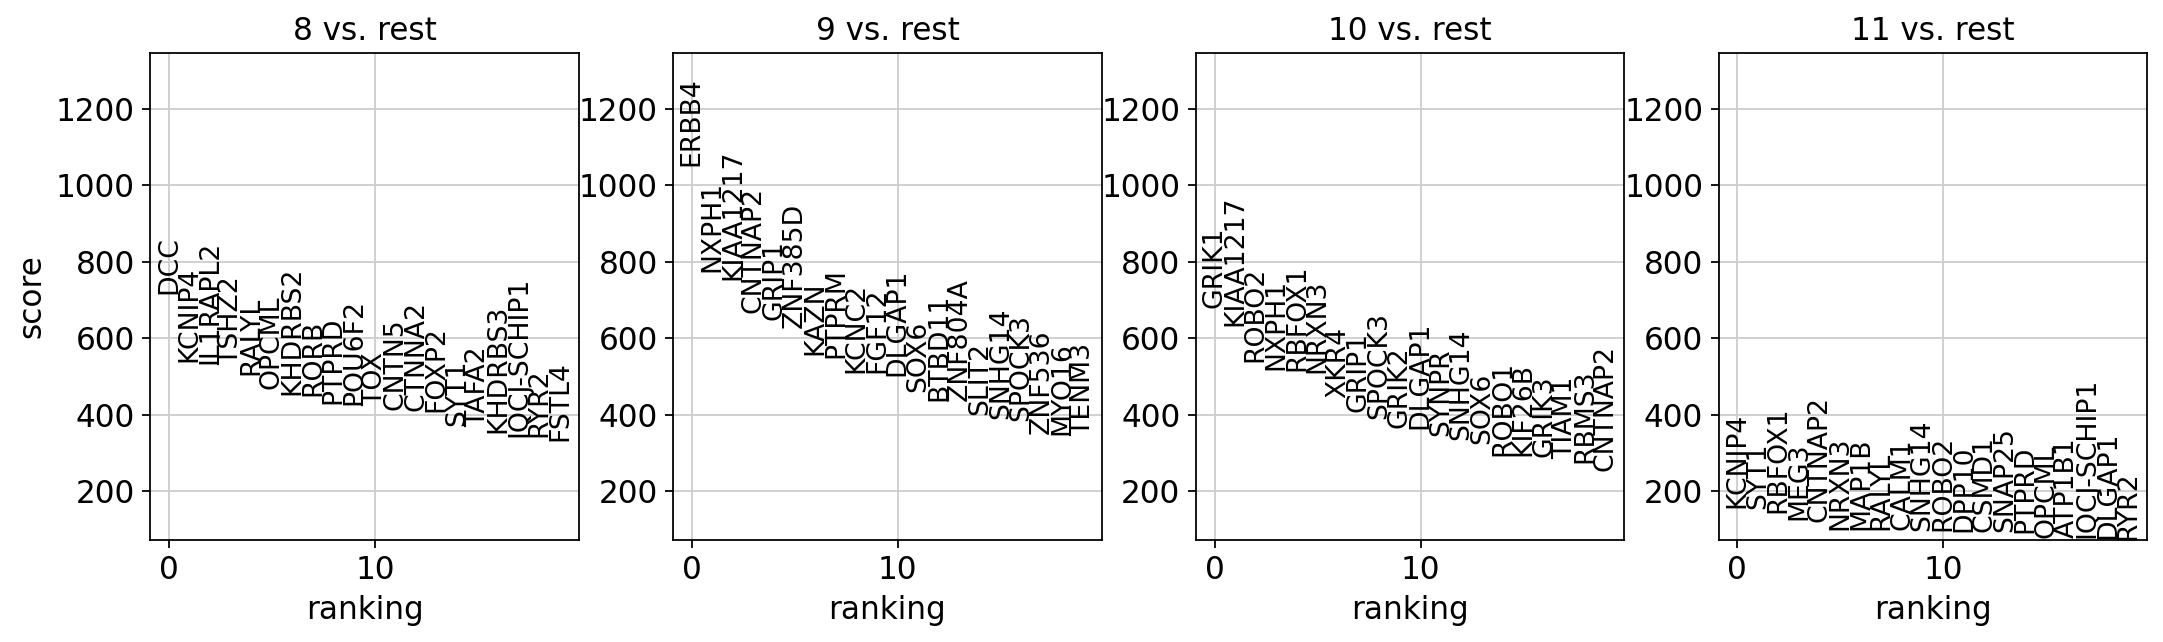

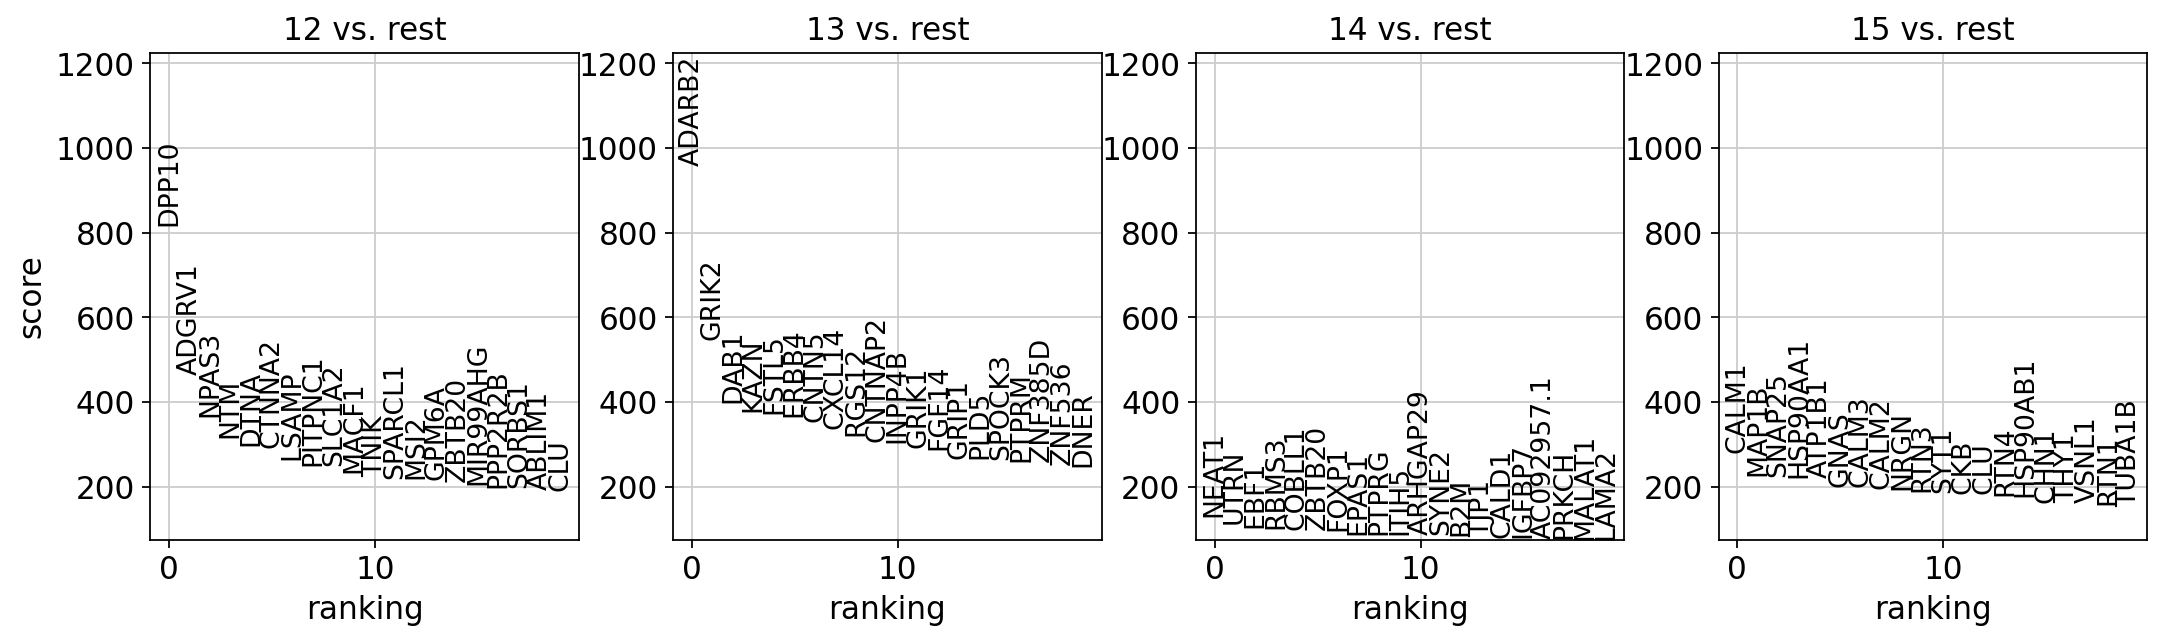

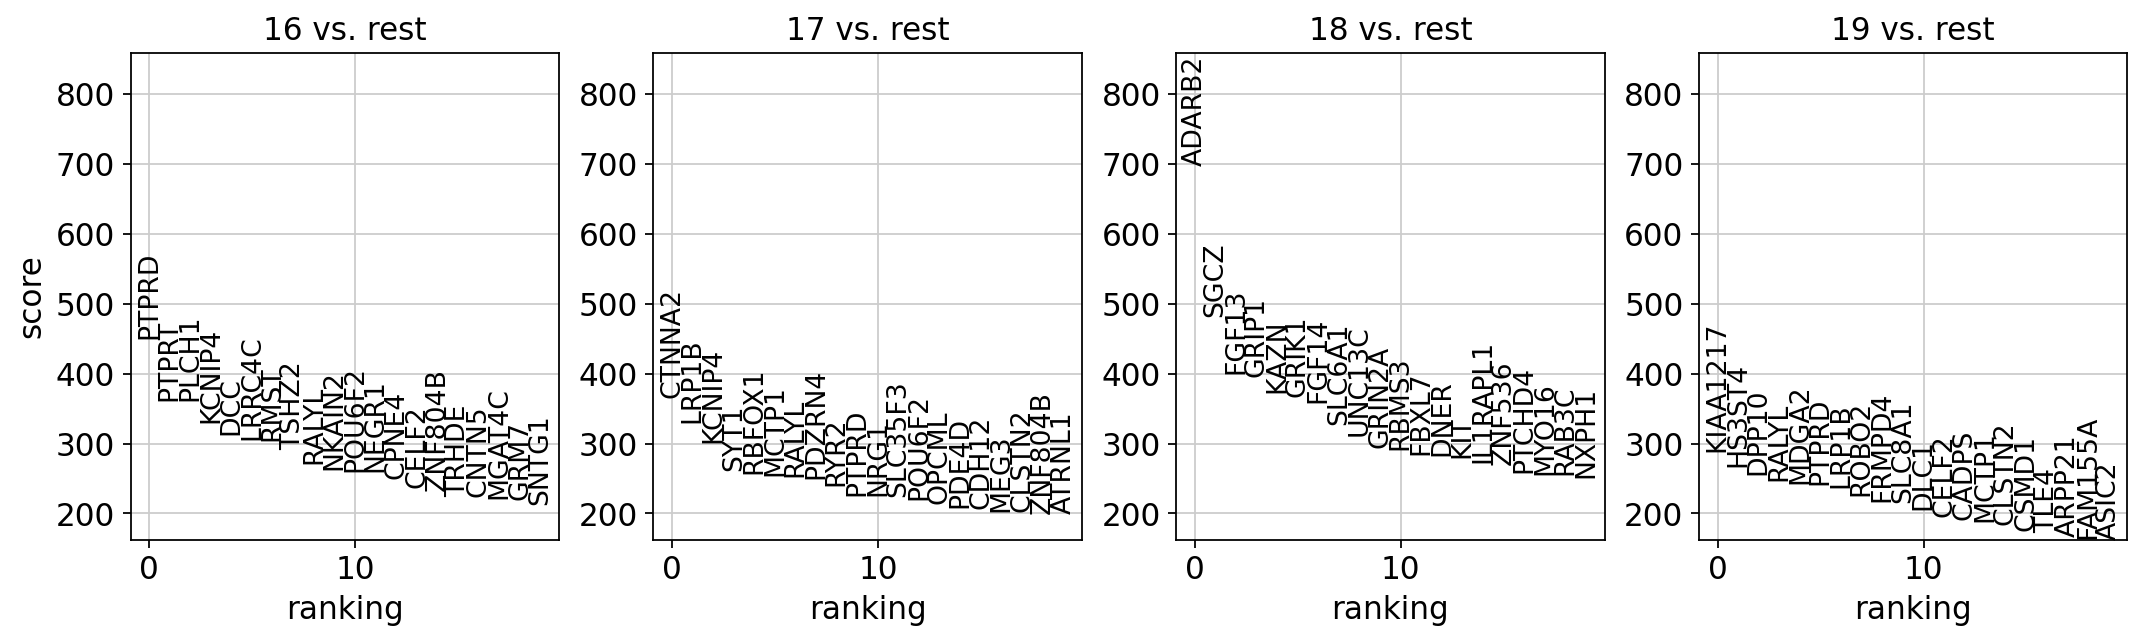

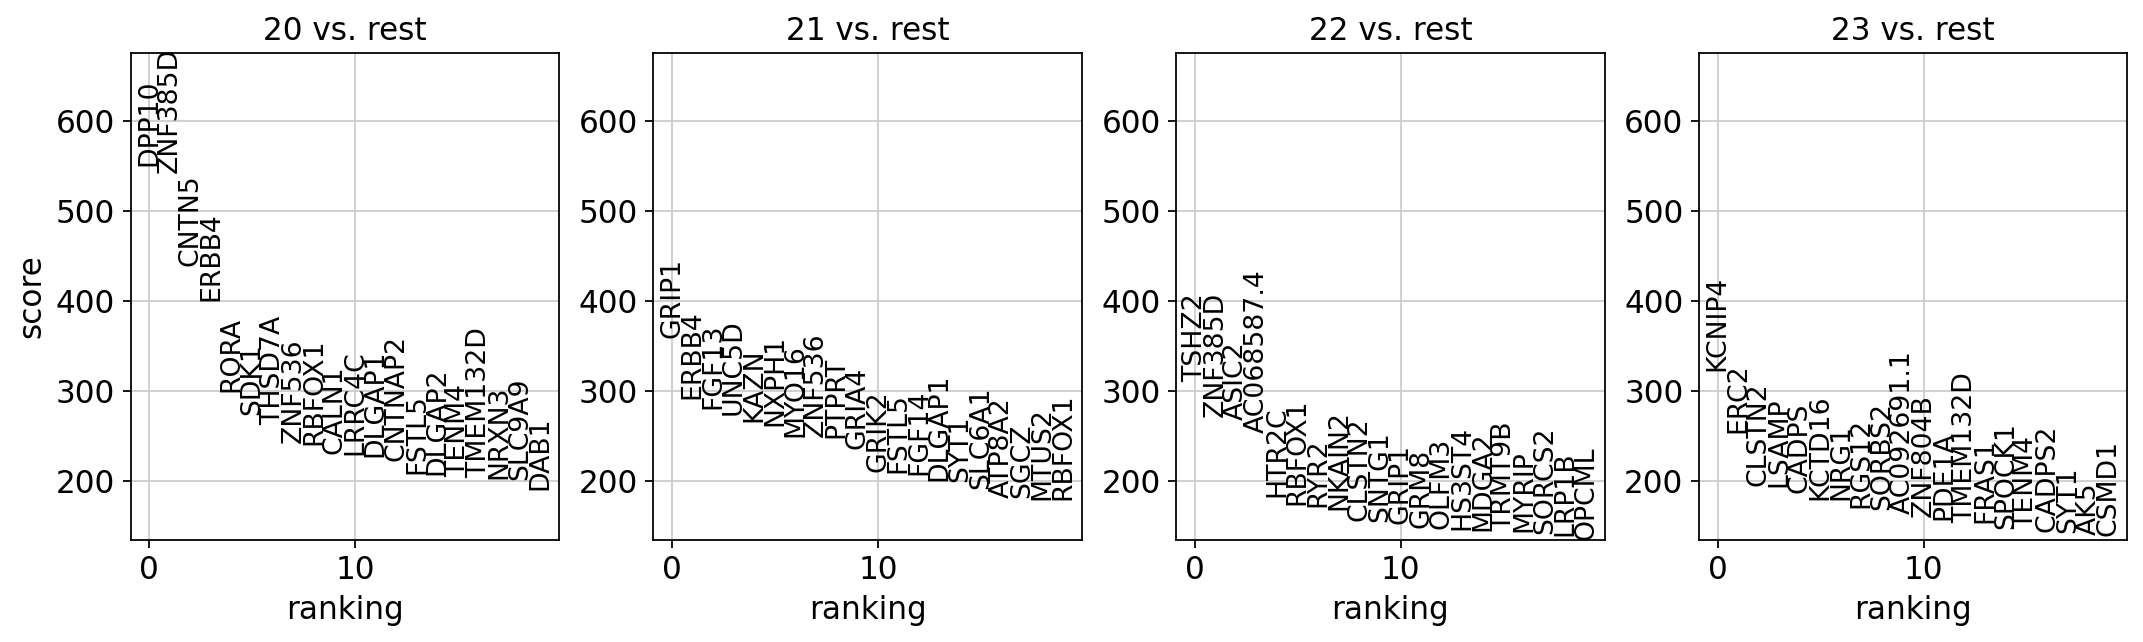

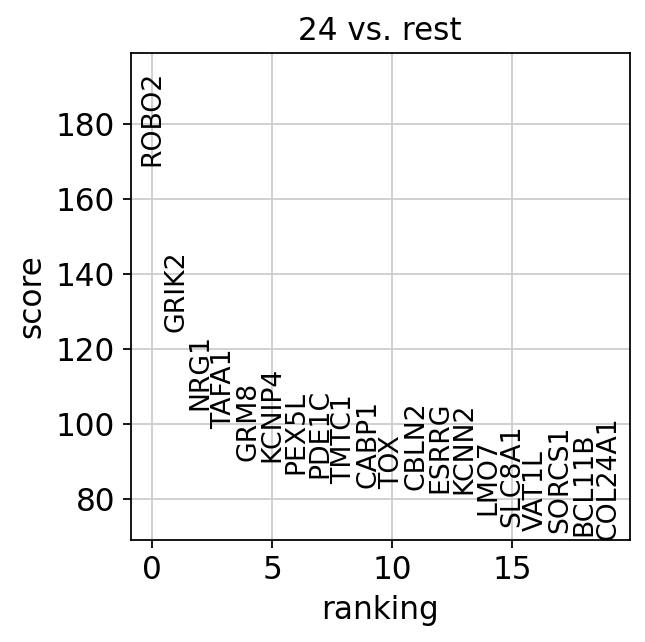

In [41]:
#Plot marker genes
sc.pl.rank_genes_groups(adata, key='rank_genes_r0.8', groups=['0','1','2','3'], fontsize=12)
sc.pl.rank_genes_groups(adata, key='rank_genes_r0.8', groups=['4','5','6','7'], fontsize=12)
sc.pl.rank_genes_groups(adata, key='rank_genes_r0.8', groups=['8','9','10','11'], fontsize=12)
sc.pl.rank_genes_groups(adata, key='rank_genes_r0.8', groups=['12','13','14','15'], fontsize=12)
sc.pl.rank_genes_groups(adata, key='rank_genes_r0.8', groups=['16','17','18','19'], fontsize=12)
sc.pl.rank_genes_groups(adata, key='rank_genes_r0.8', groups=['20','21', '22', '23'], fontsize=12)
sc.pl.rank_genes_groups(adata, key='rank_genes_r0.8', groups=['24'], fontsize=12)

# 4. Write adata

In [42]:
adata

AnnData object with n_obs × n_vars = 812585 × 26182
    obs: 'sample', 'individual', 'region', 'experiment', 'batch', 'SU.Number', 'Age', 'AgeBin', 'Sex', 'Ethnic.origin', 'Status', 'Classification', 'Classification.detail', 'Trauma.Code', 'Trauma.notes.medical.history', 'PMI', 'Hemisphere', 'Brain.pH', 'RIN', 'Chlorpromazine.equivalent', 'Antidepressants', 'Mode.of.death', 'Manner.of.Death', 'Suicide', 'COD.category', 'positive.Toxicology', 'Antipsychotics', 'Duration.of.psych.illness', 'Antipsychotics.meds.pres', 'Smoking.status', 'Freezer.storage.time..days.', 'alcohol.intake..g.day.past.12.mth.', 'Age.of.onset', 'Agonal.score', 'Main.Batch', '6-Batch', 'Position', 'Group', 'Operator', 'aaa', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'n_counts', 'n_gene

In [43]:
#Write data
adata.write(p['writedir']+'adata_labelTransfer_celltypes_samplesFilt.h5ad')

In [5]:
adata = sc.read(p['writedir']+'adata_labelTransfer_celltypes_samplesFilt.h5ad')

In [6]:
print(adata.layers['counts'])

  (0, 37)	1.0
  (0, 154)	2.0
  (0, 156)	1.0
  (0, 195)	1.0
  (0, 227)	2.0
  (0, 369)	1.0
  (0, 374)	1.0
  (0, 381)	1.0
  (0, 441)	1.0
  (0, 575)	1.0
  (0, 611)	1.0
  (0, 707)	1.0
  (0, 714)	1.0
  (0, 724)	2.0
  (0, 780)	1.0
  (0, 808)	1.0
  (0, 825)	1.0
  (0, 844)	1.0
  (0, 910)	1.0
  (0, 914)	1.0
  (0, 932)	5.0
  (0, 934)	2.0
  (0, 958)	1.0
  (0, 962)	1.0
  (0, 973)	2.0
  :	:
  (813094, 25394)	1.0
  (813094, 25464)	2.0
  (813094, 25479)	1.0
  (813094, 25524)	1.0
  (813094, 25537)	1.0
  (813094, 25542)	1.0
  (813094, 25605)	1.0
  (813094, 25649)	1.0
  (813094, 25664)	1.0
  (813094, 25668)	1.0
  (813094, 25697)	1.0
  (813094, 25735)	1.0
  (813094, 25753)	1.0
  (813094, 25764)	2.0
  (813094, 25816)	1.0
  (813094, 25918)	2.0
  (813094, 25920)	1.0
  (813094, 26041)	1.0
  (813094, 26059)	1.0
  (813094, 26062)	4.0
  (813094, 26097)	1.0
  (813094, 26159)	1.0
  (813094, 26161)	2.0
  (813094, 26172)	1.0
  (813094, 26174)	1.0


In [8]:
print(adata.layers['sct_corrected'])

  (0, 37)	1.0986122886681096
  (0, 135)	0.6931471805599453
  (0, 154)	1.9459101490553132
  (0, 156)	1.0986122886681096
  (0, 169)	0.6931471805599453
  (0, 176)	0.6931471805599453
  (0, 195)	1.0986122886681096
  (0, 227)	2.1972245773362196
  (0, 318)	0.6931471805599453
  (0, 369)	1.0986122886681096
  (0, 374)	1.0986122886681096
  (0, 381)	1.3862943611198906
  (0, 441)	1.0986122886681096
  (0, 575)	1.0986122886681096
  (0, 611)	1.0986122886681096
  (0, 627)	0.6931471805599453
  (0, 674)	0.6931471805599453
  (0, 707)	1.0986122886681096
  (0, 714)	1.0986122886681096
  (0, 724)	1.6094379124341003
  (0, 780)	1.0986122886681096
  (0, 788)	0.6931471805599453
  (0, 799)	0.6931471805599453
  (0, 808)	1.0986122886681096
  (0, 825)	1.3862943611198906
  :	:
  (813094, 25649)	0.6931471805599453
  (813094, 25664)	1.0986122886681096
  (813094, 25668)	1.0986122886681096
  (813094, 25697)	1.0986122886681096
  (813094, 25735)	1.0986122886681096
  (813094, 25747)	0.6931471805599453
  (813094, 25753)	1.098

In [7]:
print(adata.X)

  (0, 37)	1.0986122886681096
  (0, 135)	0.6931471805599453
  (0, 154)	1.9459101490553132
  (0, 156)	1.0986122886681096
  (0, 169)	0.6931471805599453
  (0, 176)	0.6931471805599453
  (0, 195)	1.0986122886681096
  (0, 227)	2.1972245773362196
  (0, 318)	0.6931471805599453
  (0, 369)	1.0986122886681096
  (0, 374)	1.0986122886681096
  (0, 381)	1.3862943611198906
  (0, 441)	1.0986122886681096
  (0, 575)	1.0986122886681096
  (0, 611)	1.0986122886681096
  (0, 627)	0.6931471805599453
  (0, 674)	0.6931471805599453
  (0, 707)	1.0986122886681096
  (0, 714)	1.0986122886681096
  (0, 724)	1.6094379124341003
  (0, 780)	1.0986122886681096
  (0, 788)	0.6931471805599453
  (0, 799)	0.6931471805599453
  (0, 808)	1.0986122886681096
  (0, 825)	1.3862943611198906
  :	:
  (813094, 25649)	0.6931471805599453
  (813094, 25664)	1.0986122886681096
  (813094, 25668)	1.0986122886681096
  (813094, 25697)	1.0986122886681096
  (813094, 25735)	1.0986122886681096
  (813094, 25747)	0.6931471805599453
  (813094, 25753)	1.098

In [11]:
print(type(adata.X))

<class 'scipy.sparse.csr.csr_matrix'>


<Figure size 320x320 with 0 Axes>

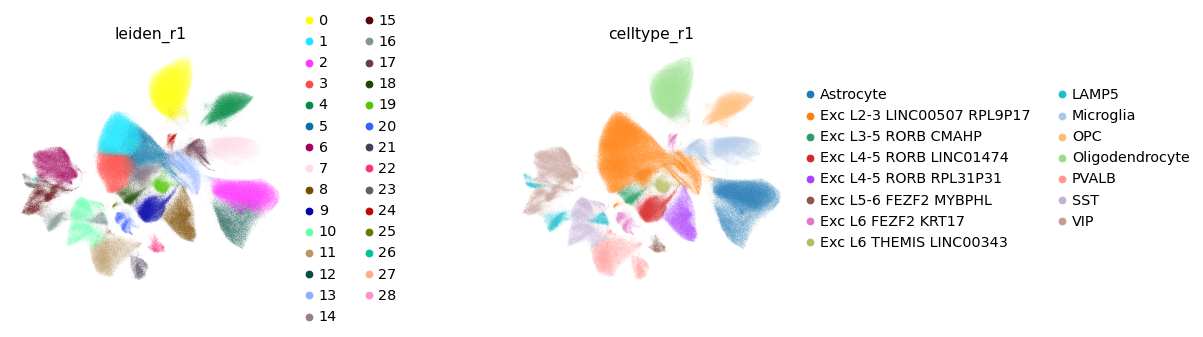

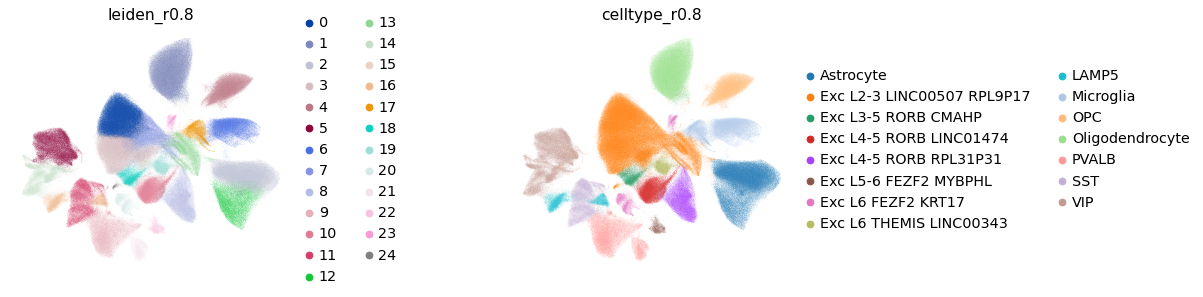

In [49]:
plt.figure()
sc.pl.umap(
    adata,
    color=["leiden_r1", "celltype_r1"],
    frameon=False,
    wspace=0.6,
)
sc.pl.umap(
    adata,
    color=["leiden_r0.8", "celltype_r0.8"],
    frameon=False,
    wspace=0.6,
)

In [50]:
sc.settings.set_figure_params(dpi=600, frameon=False)
sc.set_figure_params(dpi=600)
sc.set_figure_params(figsize=(6, 6))

In [ ]:
sc.pl.umap(
    adata,
    color=["celltype_r1"],
    frameon=False,
    wspace=0.6,
)
sc.pl.umap(
    adata,
    color=["sample"],
    frameon=False,
    wspace=0.6,
)

In [52]:
df = adata.obs
status = df.groupby(['celltype_r1', 'Status']).size().to_frame()
celltype = df.groupby(['celltype_r1']).size().to_frame()
status = status.merge(celltype, how = 'left', left_index = True, right_index = True)
status['perc'] = status['0_x']/status['0_y']
#status['celltype_r1'] = status.index
status = status.reset_index()
status

celltype_r1  Status     0_x     0_y      perc
0                    Astrocyte       0   38285  113140  0.338386
1                    Astrocyte       1   74855  113140  0.661614
2   Exc L2-3 LINC00507 RPL9P17       0   91833  244728  0.375245
3   Exc L2-3 LINC00507 RPL9P17       1  152895  244728  0.624755
4          Exc L3-5 RORB CMAHP       0    4573   12152  0.376317
5          Exc L3-5 RORB CMAHP       1    7579   12152  0.623683
6      Exc L4-5 RORB LINC01474       0   12808   35090  0.365004
7      Exc L4-5 RORB LINC01474       1   22282   35090  0.634996
8       Exc L4-5 RORB RPL31P31       0   13039   36166  0.360532
9       Exc L4-5 RORB RPL31P31       1   23127   36166  0.639468
10       Exc L5-6 FEZF2 MYBPHL       0    1448    4164  0.347743
11       Exc L5-6 FEZF2 MYBPHL       1    2716    4164  0.652257
12          Exc L6 FEZF2 KRT17       0    3673   10856  0.338338
13          Exc L6 FEZF2 KRT17       1    7183   10856  0.661662
14     Exc L6 THEMIS LINC00343       0    3925   11187  0.350854
15     Exc L6 THEMIS LINC00343       1    7262   11187  0.649146
16                       LAMP5       0    6698   18614  0.359837
17                       LAMP5       1   11916   18614  0.640163
18                   Microglia       0   22030   53748  0.409876
19                   Microglia       1   31718   53748  0.590124
20                         OPC       0   16480   45427  0.362780
21                         OPC       1   28947   45427  0.637220
22             Oligodendrocyte       0   32869   92744  0.354406
23             Oligodendrocyte       1   59875   92744  0.645594
24                       PVALB       0   14080   38259  0.368018
25                       PVALB       1   24179   38259  0.631982
26                         SST       0   14373   34069  0.421879
27                         SST       1   19696   34069  0.578121
28                         VIP       0   22687   62751  0.361540
29                         VIP       1   40064   62751  0.638460

In [53]:
status1 = status.pivot(index='celltype_r1', columns='Status', values='perc')
status1 = status1.reset_index()
status1

Status                 celltype_r1         0         1
0                        Astrocyte  0.338386  0.661614
1       Exc L2-3 LINC00507 RPL9P17  0.375245  0.624755
2              Exc L3-5 RORB CMAHP  0.376317  0.623683
3          Exc L4-5 RORB LINC01474  0.365004  0.634996
4           Exc L4-5 RORB RPL31P31  0.360532  0.639468
5            Exc L5-6 FEZF2 MYBPHL  0.347743  0.652257
6               Exc L6 FEZF2 KRT17  0.338338  0.661662
7          Exc L6 THEMIS LINC00343  0.350854  0.649146
8                            LAMP5  0.359837  0.640163
9                        Microglia  0.409876  0.590124
10                             OPC  0.362780  0.637220
11                 Oligodendrocyte  0.354406  0.645594
12                           PVALB  0.368018  0.631982
13                             SST  0.421879  0.578121
14                             VIP  0.361540  0.638460

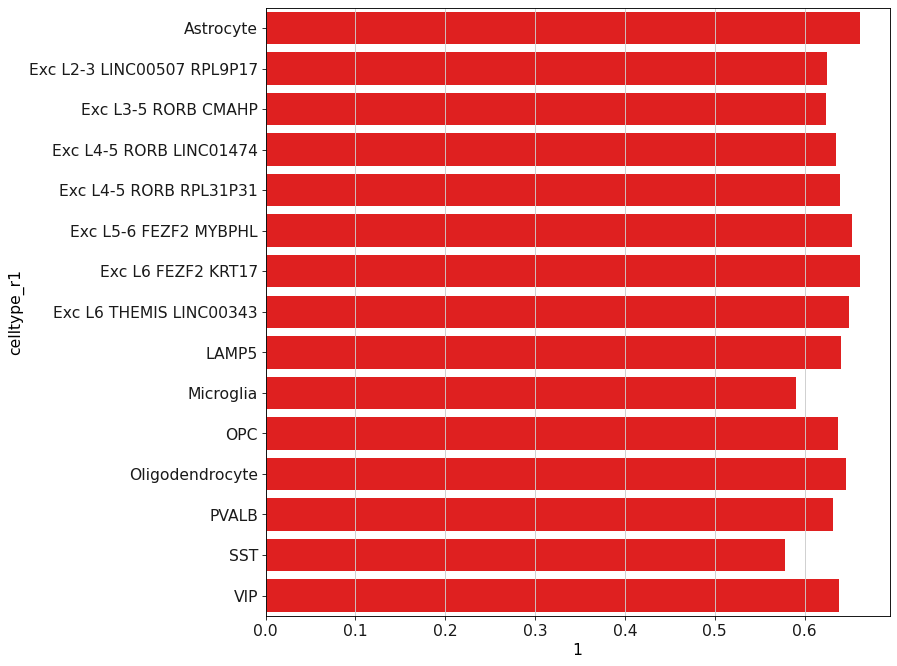

In [54]:
f, ax = plt.subplots(figsize=(10, 10))
sb.set_color_codes("pastel")
s1 = sb.barplot(y="celltype_r1", x=0, data=status1,
            label="control", color = "green")

sb.set_color_codes("muted")
s2 = sb.barplot(y="celltype_r1", x=1, data=status1,
            label="case", color = "red") 


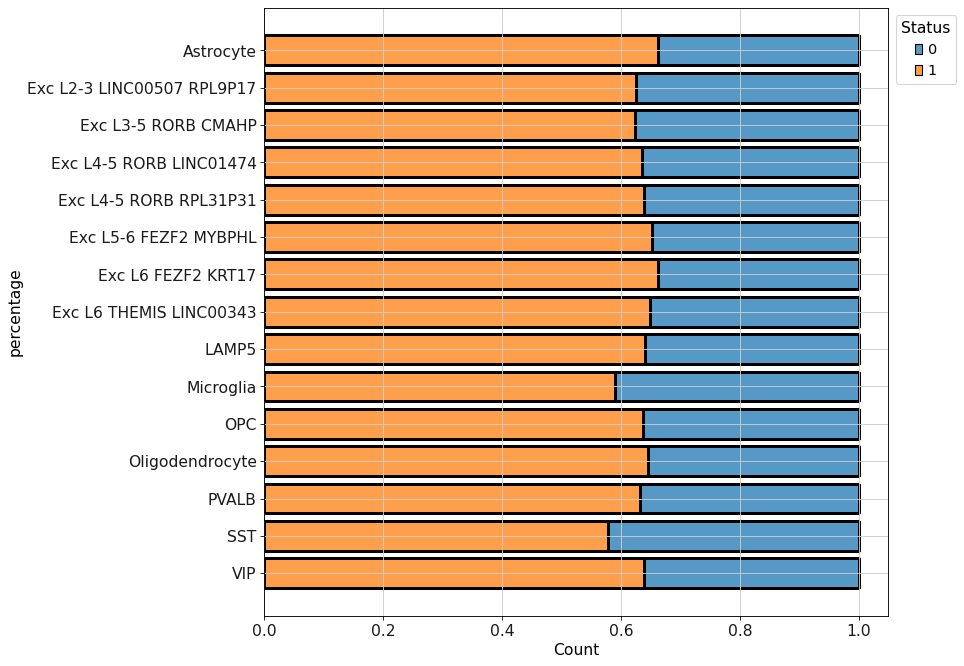

In [55]:
f, ax = plt.subplots(figsize=(10, 10))
ax = sb.histplot(status, y='celltype_r1', hue='Status', weights='perc',
             multiple='stack', shrink=0.8)
ax.set_ylabel('percentage')
# Fix the legend so it's not on top of the bars.
legend = ax.get_legend()
legend.set_bbox_to_anchor((1, 1))